# **Prepare Data**

## **Import Library**

In [1]:
# Import library
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

## **Load Data**

In [2]:
# Load Data
path = "../Data Arduino 4 treatment/fixed_formatData.xlsx"
df = pd.read_excel(path)
df

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan
0     151  149.0  106.40                73          0            1
1     151  149.0  109.78                73          0            1
2     149  149.0  106.40                73          0            1
3     149  149.0  130.06                73          0            1
4     149  151.4  106.40                73          0            1
...   ...    ...     ...               ...        ...          ...
1436  147  151.4  136.82                64          3            4
1437  149  153.8  140.20                64          3            4
1438  147  153.8  113.16                64          3            4
1439  149  153.8  123.30                64          3            4
1440  149  151.4  140.20                64          3            4

[1441 rows x 6 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R                 1441 non-null   int64  
 1   G                 1441 non-null   float64
 2   B                 1441 non-null   float64
 3   IR_Intensity (%)  1441 non-null   int64  
 4   Perlakuan         1441 non-null   int64  
 5   Pengambilan       1441 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 67.7 KB


## **Ekstraksi Fitur**

### **Normalisasi Kanal RGB**

In [4]:
def normalize_rgb(df):
    # Salin dataframe
    df_norm = df.copy()
    # Normalisasi kolom R, G, dan B
    df_norm['r'] = df_norm['R'] / 255
    df_norm['g'] = df_norm['G'] / 255
    df_norm['b'] = df_norm['B'] / 255

    return df_norm

In [5]:
df_norm= normalize_rgb(df)
df_norm

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  
0     0.584314  0.417255  
1     0.584314  0.430510  
2     0.584314  0.417255  
3     0.584314  0.510039  
4     0.593725  0.417255  
...        ...       ...  
1436  0.593725  0.536549  
1437  0.603137  0.549804  
1438  0.603137  0.443765  
1439  0.603137  0.483529  
1440  0.593725  0.549804  

[1441 rows x 9 columns]

### **Perbandingan Kanal**

In [6]:
def calculate_ratios(df):
    # Membuat salinan DataFrame agar yang asli tidak berubah
    df_rasio = df.copy()

    # Hitung rasio R/G
    df_rasio['R/Gratio'] = df_rasio['R'] / df_rasio['G']

    # Hitung rasio G/B
    df_rasio['G/Bratio'] = df_rasio['G'] / df_rasio['B']

    return df_rasio

In [7]:
df_rasio = calculate_ratios(df_norm)
df_rasio

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R/Gratio  G/Bratio  
0     0.584314  0.417255  1.013423  1.400376  
1     0.584314  0.430510  1.013423  1.357260  
2     0.584314  0.417255  1.000000  1.400376  
3     0.584314  0.510039  1.000000  1.145625  
4     0.593725  0.417255  0.984148  1.422932  
...        ...       ...       ...       ...  
1436  0.593725  0.536549  0.970938  1.106563  
1437  0.603137  0.549804  0.968791  1.097004  
1438  0.603137  0.443765  0.955787  1.359138  
1439  0.603137  0.483529  0.968791  1.247364  
1440  0.593725  0.549804  0.984148  1.079886  

[1441 rows x 11 columns]

### **Mencari Nilai HSV**

In [8]:
def rgb_to_hsv(df):
    # Salin dataframe
    df_hsv = df.copy()
    
    # Ekstrak kolom r, g, dan b
    r = df_hsv['r']
    g = df_hsv['g']
    b = df_hsv['b']

    # Hitung nilai maksimum (V) dan minimum (m)
    cmax = np.maximum.reduce([r, g, b])
    cmin = np.minimum.reduce([r, g, b])
    delta = cmax - cmin

    # Hitung Hue (H)
    def calculate_hue():
        hue = np.zeros_like(delta)  # Default hue adalah 0
        mask_r_max = (cmax == r) & (delta != 0)
        mask_g_max = (cmax == g) & (delta != 0)
        mask_b_max = (cmax == b) & (delta != 0)

        # Rumus untuk hue jika R adalah maksimum
        hue[mask_r_max] = (60 * ((g[mask_r_max] - b[mask_r_max]) / delta[mask_r_max]) + 360) % 360

        # Rumus untuk hue jika G adalah maksimum
        hue[mask_g_max] = (60 * ((b[mask_g_max] - r[mask_g_max]) / delta[mask_g_max]) + 120) % 360

        # Rumus untuk hue jika B adalah maksimum
        hue[mask_b_max] = (60 * ((r[mask_b_max] - g[mask_b_max]) / delta[mask_b_max]) + 240) % 360

        return hue

    h = calculate_hue()

    # Hitung Saturation (S)
    s = np.where(cmax != 0, delta / cmax, 0)

    # Value (V) adalah nilai maksimum
    v = cmax

    # Tambahkan kolom h, s, dan v ke DataFrame
    df_hsv['H'] = h
    df_hsv['S'] = s
    df_hsv['V'] = v

    return df_hsv

In [9]:
df_hsv = rgb_to_hsv(df_rasio)
df_hsv

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R/Gratio  G/Bratio          H         S         V  
0     0.584314  0.417255  1.013423  1.400376  57.309417  0.295364  0.592157  
1     0.584314  0.430510  1.013423  1.357260  57.088792  0.272980  0.592157  
2     0.584314  0.417255  1.000000  1.400376  60.000000  0.285906  0.584314  
3     0.584314  0.510039  1.000000  1.145625  60.000000  0.127114  0.584314  
4     0.593725  0.417255  0.984148  1.422932  63.200000  0.297226  0.593725  
...        ...       ...       ...       ...        ...       ...       ...  
1436  0.593725  0.536549  0.970938  1.106563  78.106996  0.096301  0.593725  
1437  0.603137  0.549804  0.968791  1.097004  81.176471  0.088427  0.603137  
1438  0.603137  0.443765  0.955787  1.359138  70.039370  0.264239  0.603137  
1439  0.603137  0.483529  0.968791  1.247364  69.442623  0.198309  0.603137  
1440  0.593725  0.549804  0.984148  1.079886  72.857143  0.073976  0.593725  

[1441 rows x 14 columns]

### **Mencari Nilai Lab**

#### **Hitung Manual**

In [10]:
def rgb_to_lab(df):
    # Membuat salinan DataFrame agar yang asli tidak berubah
    df_lab = df.copy()

    # Normalisasi RGB ke rentang [0, 1]
    r = df_lab['r']
    g = df_lab['g']
    b = df_lab['b']

    # Koreksi gamma untuk nilai RGB
    def gamma_correction(c):
        return np.where(c > 0.04045, ((c + 0.055) / 1.055) ** 2.4, c / 12.92)

    # Terapkan koreksi gamma
    r_linear = gamma_correction(r)
    g_linear = gamma_correction(g)
    b_linear = gamma_correction(b)

    # Transformasi RGB ke XYZ menggunakan matriks standar
    X = 0.4124564 * r_linear + 0.3575761 * g_linear + 0.1804375 * b_linear
    Y = 0.2126729 * r_linear + 0.7151522 * g_linear + 0.0721750 * b_linear
    Z = 0.0193339 * r_linear + 0.1191920 * g_linear + 0.9503041 * b_linear

    # Nilai referensi untuk XYZ (D65/2° standard illuminant)
    Xn, Yn, Zn = 0.95047, 1.0, 1.08883

    # Fungsi untuk menghitung f(t)
    def f(t):
        return np.where(t > 0.008856, t ** (1/3), 7.787 * t + 16/116)

    # Hitung L, a, dan b
    L = 116 * f(Y / Yn) - 16
    a = 500 * (f(X / Xn) - f(Y / Yn))
    b = 200 * (f(Y / Yn) - f(Z / Zn))

    # Tambahkan kolom L, a, dan b ke DataFrame
    df_lab['cL'] = L
    df_lab['ca'] = a
    df_lab['cb'] = b

    return df_lab

In [11]:
df_lab=rgb_to_lab(df_hsv)
df_lab

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R/Gratio  G/Bratio          H         S         V  \
0     0.584314  0.417255  1.013423  1.400376  57.309417  0.295364  0.592157   
1     0.584314  0.430510  1.013423  1.357260  57.088792  0.272980  0.592157   
2     0.584314  0.417255  1.000000  1.400376  60.000000  0.285906  0.584314   
3     0.584314  0.510039  1.000000  1.145625  60.000000  0.127114  0.584314   
4     0.593725  0.417255  0.984148  1.422932  63.200000  0.297226  0.593725   
...        ...       ...       ...       ...        ...       ...       ...   
1436  0.593725  0.536549  0.970938  1.106563  78.106996  0.096301  0.593725   
1437  0.603137  0.549804  0.968791  1.097004  81.176471  0.088427  0.603137   
1438  0.603137  0.443765  0.955787  1.359138  70.039370  0.264239  0.603137   
1439  0.603137  0.483529  0.968791  1.247364  69.442623  0.198309  0.603137   
1440  0.593725  0.549804  0.984148  1.079886  72.857143  0.073976  0.593725   

             cL        ca         cb  
0     60.890564 -6.299734  22.830546  
1     60.953899 -5.827671  21.044019  
2     60.723155 -7.112026  22.577013  
3     61.218617 -3.447379  10.020923  
4     61.395413 -8.411532  23.476470  
...         ...       ...        ...  
1436  61.883257 -4.341136   7.130325  
1437  62.788701 -4.301695   6.543102  
1438  62.035710 -9.534773  20.581252  
1439  62.399884 -7.187258  15.471242  
1440  62.126888 -2.982561   5.593500  

[1441 rows x 17 columns]

#### **Hitung Dengan Library OpenCV**

In [12]:
def rgb_to_lab_with_opencv(df):

    # Membuat salinan DataFrame agar yang asli tidak berubah
    df_cv = df.copy()

    # Konversi RGB ke LAB menggunakan OpenCV
    rgb_values = df_cv[['R', 'G', 'B']].values.astype(np.uint8)
    rgb_values = rgb_values[:, ::-1]
    lab_values = cv2.cvtColor(rgb_values.reshape(1, -1, 3), cv2.COLOR_BGR2LAB).reshape(-1, 3)

    # Pisahkan nilai L, a, dan b
    L = lab_values[:, 0] * (100 / 255)  # Konversi L ke rentang [0, 100]
    
    # Ubah tipe data a dan b ke float sebelum penggeseran
    a = lab_values[:, 1].astype(float) - 128  # Geser a ke rentang [-128, 127]
    b = lab_values[:, 2].astype(float) - 128  # Geser b ke rentang [-128, 127]

    # Tambahkan kolom cL, ca, dan cb ke DataFrame
    df_cv['cL'] = L
    df_cv['ca'] = a
    df_cv['cb'] = b

    return df_cv

In [13]:
df_cv=rgb_to_lab_with_opencv(df_hsv)
df_cv

R      G       B  IR_Intensity (%)  Perlakuan  Pengambilan         r  \
0     151  149.0  106.40                73          0            1  0.592157   
1     151  149.0  109.78                73          0            1  0.592157   
2     149  149.0  106.40                73          0            1  0.584314   
3     149  149.0  130.06                73          0            1  0.584314   
4     149  151.4  106.40                73          0            1  0.584314   
...   ...    ...     ...               ...        ...          ...       ...   
1436  147  151.4  136.82                64          3            4  0.576471   
1437  149  153.8  140.20                64          3            4  0.584314   
1438  147  153.8  113.16                64          3            4  0.576471   
1439  149  153.8  123.30                64          3            4  0.584314   
1440  149  151.4  140.20                64          3            4  0.584314   

             g         b  R/Gratio  G/Bratio          H         S         V  \
0     0.584314  0.417255  1.013423  1.400376  57.309417  0.295364  0.592157   
1     0.584314  0.430510  1.013423  1.357260  57.088792  0.272980  0.592157   
2     0.584314  0.417255  1.000000  1.400376  60.000000  0.285906  0.584314   
3     0.584314  0.510039  1.000000  1.145625  60.000000  0.127114  0.584314   
4     0.593725  0.417255  0.984148  1.422932  63.200000  0.297226  0.593725   
...        ...       ...       ...       ...        ...       ...       ...   
1436  0.593725  0.536549  0.970938  1.106563  78.106996  0.096301  0.593725   
1437  0.603137  0.549804  0.968791  1.097004  81.176471  0.088427  0.603137   
1438  0.603137  0.443765  0.955787  1.359138  70.039370  0.264239  0.603137   
1439  0.603137  0.483529  0.968791  1.247364  69.442623  0.198309  0.603137   
1440  0.593725  0.549804  0.984148  1.079886  72.857143  0.073976  0.593725   

             cL   ca    cb  
0     60.784314 -6.0  23.0  
1     61.176471 -6.0  21.0  
2     60.784314 -7.0  23.0  
3     61.176471 -4.0  10.0  
4     61.176471 -8.0  23.0  
...         ...  ...   ...  
1436  61.960784 -4.0   7.0  
1437  62.745098 -4.0   6.0  
1438  61.960784 -9.0  20.0  
1439  62.352941 -7.0  15.0  
1440  61.960784 -3.0   5.0  

[1441 rows x 17 columns]

# **Seleksi Fitur Gabungan Fitur**

## **Import Library**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
import warnings
import itertools
import time

In [15]:
# Matikan FutureWarning, ConvergenceWarning, dan UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## **Mempersiapkan Data**

In [16]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R                 1441 non-null   int64  
 1   G                 1441 non-null   float64
 2   B                 1441 non-null   float64
 3   IR_Intensity (%)  1441 non-null   int64  
 4   Perlakuan         1441 non-null   int64  
 5   Pengambilan       1441 non-null   int64  
 6   r                 1441 non-null   float64
 7   g                 1441 non-null   float64
 8   b                 1441 non-null   float64
 9   R/Gratio          1441 non-null   float64
 10  G/Bratio          1441 non-null   float64
 11  H                 1441 non-null   float64
 12  S                 1441 non-null   float64
 13  V                 1441 non-null   float64
 14  cL                1441 non-null   float64
 15  ca                1441 non-null   float64
 16  cb                1441 non-null   float64


### **Membuat Kombinasi Grup**

In [17]:
# Data input
grup_fitur = {
    'RGB': ['R', 'G', 'B'],
    'rgb': ['r', 'g', 'b'],
    'HSV': ['H', 'S', 'V'],
    'CLab': ['cL', 'ca', 'cb'],
    'R/Gratio': ['R/Gratio'],
    'G/Bratio': ['G/Bratio'],
}

# Inisialisasi kamus kombinasi
kombinasi_grup = {}

# Tambahkan semua grup individu terlebih dahulu
for group_name, features in grup_fitur.items():
    kombinasi_grup[group_name] = grup_fitur[group_name]

# Buat set fitur "Full" dengan semua fitur yang digabungkan
all_features = []
for features in grup_fitur.values():
    all_features.extend(features)
kombinasi_grup['Full'] = all_features

# Hasilkan kombinasi dari 2 grup fitur
groups = list(grup_fitur.keys())
for i, j in itertools.combinations(groups, 2):
    combo_name = f"{i}_{j}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j]

# Hasilkan kombinasi dari 3 grup fitur
for i, j, k in itertools.combinations(groups, 3):
    combo_name = f"{i}_{j}_{k}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j] + grup_fitur[k]

# Hasilkan kombinasi dari 4 grup fitur
for i, j, k, l in itertools.combinations(groups, 4):
    combo_name = f"{i}_{j}_{k}_{l}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j] + grup_fitur[k] + grup_fitur[l]

# Hasilkan kombinasi dari 5 grup fitur
for i, j, k, l, m in itertools.combinations(groups, 5):
    combo_name = f"{i}_{j}_{k}_{l}_{m}"
    kombinasi_grup[combo_name] = grup_fitur[i] + grup_fitur[j] + grup_fitur[k] + grup_fitur[l] + grup_fitur[m]

### **Membuat Dictionary**

In [18]:
def prepare_data_variasi_fitur(df, kombinasi_grup):
    hasil_split = {}

    for nama_grup, fitur in kombinasi_grup.items():
        X = df[fitur]
        y = df['Perlakuan']

        # Membagi data menjadi set pelatihan dan pengujian
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Preprocessing data tanpa split untuk ANN: StandardScaler
        scaler_ann = StandardScaler()
        # Preprocessing untuk ANN: StandardScaler
        X_train_ann = scaler_ann.fit_transform(X_train)
        X_test_ann = scaler_ann.transform(X_test)
        
        # Preprocessing data tanpa split untuk AdaBoost SVM: StandardScaler
        scaler_svm = StandardScaler()
        X_train_svm = scaler_svm.fit_transform(X_train)
        X_test_svm = scaler_svm.transform(X_test)

        # Preprocessing untuk AdaBoost DT: Tanpa scaling
        X_train_dt = X_train.values
        X_test_dt = X_test.values

        hasil_split[nama_grup] = {
            'X_train_ann': X_train_ann, 'X_test_ann': X_test_ann,
            'X_train_svm': X_train_svm, 'X_test_svm': X_test_svm,
            'X_train_dt': X_train_dt, 'X_test_dt': X_test_dt,
            'y_train': y_train, 'y_test': y_test,
            'fitur': fitur
        }

        print(f"Grup: {nama_grup}")
        print(f"Jumlah fitur yang digunakan: {len(fitur)}")
        print(f"Fitur: {fitur}")
        print(f"Jumlah data training: {X_train.shape[0]}")
        print(f"Jumlah data testing: {X_test.shape[0]}")
        print(f"Jumlah data training ANN: {X_train_ann.shape[0]}")
        print(f"Jumlah data testing ANN: {X_test_ann.shape[0]}")
        print(f"Jumlah data training SVM: {X_train_svm.shape[0]}")
        print(f"Jumlah data testing SVM: {X_test_svm.shape[0]}")
        print(f"Jumlah y_train: {y_train.shape[0]}")
        print(f"Jumlah y_test: {y_test.shape[0]}")

    return hasil_split


In [19]:
data_prep = prepare_data_variasi_fitur(df_lab, kombinasi_grup)

Grup: RGB
Jumlah fitur yang digunakan: 3
Fitur: ['R', 'G', 'B']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing ANN: 433
Jumlah data training SVM: 1008
Jumlah data testing SVM: 433
Jumlah y_train: 1008
Jumlah y_test: 433
Grup: rgb
Jumlah fitur yang digunakan: 3
Fitur: ['r', 'g', 'b']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing ANN: 433
Jumlah data training SVM: 1008
Jumlah data testing SVM: 433
Jumlah y_train: 1008
Jumlah y_test: 433
Grup: HSV
Jumlah fitur yang digunakan: 3
Fitur: ['H', 'S', 'V']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing ANN: 433
Jumlah data training SVM: 1008
Jumlah data testing SVM: 433
Jumlah y_train: 1008
Jumlah y_test: 433
Grup: CLab
Jumlah fitur yang digunakan: 3
Fitur: ['cL', 'ca', 'cb']
Jumlah data training: 1008
Jumlah data testing: 433
Jumlah data training ANN: 1008
Jumlah data testing A

In [20]:
data_prep

{'RGB': {'X_train_ann': array([[ 1.56723454,  1.22336322,  0.34806141],
         [-0.05568036,  0.19057417,  0.13606993],
         [-0.05568036,  2.25615228,  0.56005289],
         ...,
         [-0.05568036, -0.49795187, -1.34787043],
         [ 0.21480545,  0.19057417,  1.62001028],
         [-3.03102435, -2.90779299, -2.6198193 ]]),
  'X_test_ann': array([[-0.46140909, -0.15368885, -0.49990451],
         [ 0.21480545, -0.15368885,  0.77204436],
         [-0.46140909, -0.15368885,  0.98403584],
         ...,
         [ 0.21480545,  0.19057417,  0.13606993],
         [-0.46140909, -0.15368885,  0.98403584],
         [-0.73189491, -0.49795187,  0.56005289]]),
  'X_train_svm': array([[ 1.56723454,  1.22336322,  0.34806141],
         [-0.05568036,  0.19057417,  0.13606993],
         [-0.05568036,  2.25615228,  0.56005289],
         ...,
         [-0.05568036, -0.49795187, -1.34787043],
         [ 0.21480545,  0.19057417,  1.62001028],
         [-3.03102435, -2.90779299, -2.6198193 ]]),
 

## **Membangun Model**

### **Artiifical Neural Network (ANN)**

#### **MLP Sklearn**

In [21]:
def train_ann(X_train, y_train, params=None):
    print("=== Melatih Model ANN ===")

    default_params = {
        "hidden_layer_sizes": (100, 50),
        "activation": "relu",
        "solver": "adam",
        "alpha": 0.0001,
        "learning_rate": "constant",
        "max_iter": 1000,
        "random_state": 42,
        "early_stopping": False,
    }

    if params:
        default_params.update(params)

    ann = MLPClassifier(**default_params)
    ann.fit(X_train, y_train)

    return ann

### **Adaboost Decision Tree**

In [22]:
def train_adaboost_dt(X_train, y_train, params=None):
    print("\n=== Melatih Model AdaBoost dengan Decision Tree ===")

    estimator = DecisionTreeClassifier(max_depth=11, random_state=42)
    default_params = {
        "estimator": estimator,
        "n_estimators": 50,
        "learning_rate": 1.0,
        "random_state": 42,
    }

    if params:
        estimator_params = {k.split('__')[1]: v for k, v in params.items() if k.startswith('estimator__')}
        default_params["estimator"].set_params(**estimator_params)
        params = {k: v for k, v in params.items() if not k.startswith('estimator__')}
        default_params.update(params)

    adaboost_dt = AdaBoostClassifier(**default_params)
    adaboost_dt.fit(X_train, y_train)

    return adaboost_dt

### **Adaboost Support Vector Machine (SVM) Kernel RBF**

In [23]:
def train_adaboost_svm(X_train, y_train, params=None):
    print("\n=== Melatih Model AdaBoost dengan SVM RBF Kernel ===")

    svc = SVC(kernel='rbf', C=1.0, gamma=10 , probability=True, random_state=42)
    default_params = {
        "estimator": svc,
        "n_estimators": 50,
        "learning_rate": 1.0,
        "random_state": 42,
    }

    if params:
        estimator_params = {k.split('__')[1]: v for k, v in params.items() if k.startswith('estimator__')}
        default_params["estimator"].set_params(**estimator_params)
        params = {k: v for k, v in params.items() if not k.startswith('estimator__')}
        default_params.update(params)

    adaboost_svm = AdaBoostClassifier(**default_params)
    adaboost_svm.fit(X_train, y_train)

    return adaboost_svm

### **Bagging Support Vector Machine (SVM) Kernel RBF**

In [24]:
def train_bagging_svm(X_train, y_train, params=None):
    print("\n=== Melatih Model Bagging dengan SVM RBF Kernel ===")

    svc = SVC(kernel='rbf', C=1.0, gamma=10 , probability=True, random_state=42)
    default_params = {
        "estimator": svc,
        "n_estimators": 50,
        "random_state": 42,
        "n_jobs": -1,
    }

    if params:
        estimator_params = {k.split('__')[1]: v for k, v in params.items() if k.startswith('estimator__')}
        default_params["estimator"].set_params(**estimator_params)
        params = {k: v for k, v in params.items() if not k.startswith('estimator__')}
        default_params.update(params)

    bagging_svm = BaggingClassifier(**default_params)
    bagging_svm.fit(X_train, y_train)

    return bagging_svm

## **Training dan Evaluasi Model**

### **Inisiasi Parameter**

In [25]:
# Daftar fitur lengkap yang digunakan
ALL_FEATURES = [
    'R', 'G', 'B', 'r', 'g', 'b', 
    'R/Gratio', 'G/Bratio', 
    'H', 'S', 'V', 
    'cL', 'ca', 'cb'
]

# Mapping kelompok fitur ke komponen penyusunnya
FEATURE_GROUP_MAP = {
    'RGB': ['R', 'G', 'B'],
    'rgb': ['r', 'g', 'b'],
    'R/Gratio': ['R/Gratio'],
    'G/Bratio': ['G/Bratio'],
    'HSV': ['H', 'S', 'V'],
    'CLab': ['cL', 'ca', 'cb'],
    # tambahkan grup lain jika ada
}


### **Fungsi Metrics Evaluasi**

In [26]:
def metrics_model(model, X, y, set_name="Data", show_report=True):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)
    else:
        y_prob = model.predict(X)

    if len(y_prob.shape) == 2 and y_prob.shape[1] > 1:
        y_pred = np.argmax(y_prob, axis=1)
    else:
        y_pred = (y_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)

    metrics = {
        "accuracy": acc,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1_score": report['weighted avg']['f1-score']
    }

    if show_report:
        print(f"\n=== Classification Report ({set_name}) ===")
        print(classification_report(y, y_pred))

    return {
        "y_pred": y_pred,
        "y_prob": y_prob,
        "metrics": metrics
    }

### **Fungsi Testing dan Evaluasi Model**

In [27]:
def get_available_key_pair(data, model_name, method= 'fc'):
    # Mapping berdasarkan model dan metode
    if method == 'fc':
        model_preprocessing_map = {
            'ANN': [('X_train_ann', 'X_test_ann')],
            'AdaBoost DT': [
                ('X_train_dt', 'X_test_dt'),
            ],
            'AdaBoost SVM': [
                ('X_train_svm', 'X_test_svm'),
            ],
            'Bagging SVM': [
                ('X_train_svm', 'X_test_svm'),
            ]
        }
    elif method == 'ag':
        model_preprocessing_map = {
            'ANN': [('X_train_ann', 'X_test_ann')],
            'AdaBoost DT': [
                ('X_train_adt', 'X_test_adt')
            ],
            'AdaBoost SVM': [
                ('X_train_absvm', 'X_test_absvm')
            ],
            'Bagging SVM': [
                ('X_train_bagsvm', 'X_test_bagsvm')
            ]
        }
    else:
        raise ValueError("Metode tidak dikenali. Pilih 'fc' atau 'ag'.")

    if model_name not in model_preprocessing_map:
        raise ValueError(f"Model {model_name} tidak dikenali.")

    for pair in model_preprocessing_map[model_name]:
        X_train_key, X_test_key = pair
        required_keys = [X_train_key, X_test_key, 'y_train', 'y_test']
        missing_keys = [key for key in required_keys if key not in data]
        if not missing_keys:
            return X_train_key, X_test_key

    raise ValueError(f"Tidak ada pasangan fitur valid untuk model '{model_name}'")

In [28]:
def evaluate_model_cv(feature_groups, model_func, model_name, n_splits=10, target_groups=None, method='fc'):
    results = {}
    metrics_data = []

    # Filter grup jika target_groups disediakan
    if target_groups:
        feature_groups = {k: v for k, v in feature_groups.items() if k in target_groups}

    # Evaluasi tiap grup fitur
    for group_name, data in feature_groups.items():
        print(f"\n=== Mengolah Grup Fitur: {group_name} dengan Model: {model_name} ===")
        start_time = time.time()

        try:
            # Cari pasangan key pertama yang tersedia
            X_train_key, X_test_key = get_available_key_pair(data, model_name, method=method)
        except ValueError as ve:
            print(f"[Error] Evaluasi gagal untuk {group_name}: {ve}")
            continue

        X_train_full = data[X_train_key]
        y_train_full = data['y_train'].values

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        fold_metrics = {
            'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
            'test_accuracy': [], 'test_precision': [], 'test_recall': [], 'test_f1': []
        }

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full), 1):
            print(f"Fold {fold}/{n_splits}")
            X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
            y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

            model = model_func(X_train, y_train)
            train_result = metrics_model(model, X_train, y_train, "Train", show_report=True)
            test_result = metrics_model(model, X_val, y_val, "Validation", show_report=True)

            # Simpan hasil metrik per fold
            fold_metrics['train_accuracy'].append(train_result['metrics']['accuracy'])
            fold_metrics['train_precision'].append(train_result['metrics']['precision'])
            fold_metrics['train_recall'].append(train_result['metrics']['recall'])
            fold_metrics['train_f1'].append(train_result['metrics']['f1_score'])

            fold_metrics['test_accuracy'].append(test_result['metrics']['accuracy'])
            fold_metrics['test_precision'].append(test_result['metrics']['precision'])
            fold_metrics['test_recall'].append(test_result['metrics']['recall'])
            fold_metrics['test_f1'].append(test_result['metrics']['f1_score'])

        avg_metrics = {
            'Train Accuracy': np.mean(fold_metrics['train_accuracy']),
            'Train Precision': np.mean(fold_metrics['train_precision']),
            'Train Recall': np.mean(fold_metrics['train_recall']),
            'Train F1-Score': np.mean(fold_metrics['train_f1']),
            'Test Accuracy': np.mean(fold_metrics['test_accuracy']),
            'Test Precision': np.mean(fold_metrics['test_precision']),
            'Test Recall': np.mean(fold_metrics['test_recall']),
            'Test F1-Score': np.mean(fold_metrics['test_f1']),
        }

        results[group_name] = {
            'model': model_name,
            'train_results': {'metrics': avg_metrics},
            'test_results': {'metrics': avg_metrics},
        }

        # Cari fitur yang dipilih
        if group_name == "Full":
            sorted_features = ALL_FEATURES
        else:
            parts = group_name.split('_')
            selected_features = set()
            for part in parts:
                if part in FEATURE_GROUP_MAP:
                    selected_features.update(FEATURE_GROUP_MAP[part])
                elif part in ALL_FEATURES:
                    selected_features.add(part)
            sorted_features = sorted(
                selected_features,
                key=lambda x: ALL_FEATURES.index(x) if x in ALL_FEATURES else float('inf')
            )

        # Hitung durasi akhir
        duration = time.time() - start_time

        metrics_data.append({
            'Feature Group': group_name,
            'Model': model_name,
            'Train Accuracy': avg_metrics['Train Accuracy'],
            'Train Precision': avg_metrics['Train Precision'],
            'Train Recall': avg_metrics['Train Recall'],
            'Train F1-Score': avg_metrics['Train F1-Score'],
            'Test Accuracy': avg_metrics['Test Accuracy'],
            'Test Precision': avg_metrics['Test Precision'],
            'Test Recall': avg_metrics['Test Recall'],
            'Test F1-Score': avg_metrics['Test F1-Score'],
            'Selected Features': ', '.join(sorted_features),
            'Processing Time (s)': round(duration, 2)
        })

    # Buat DataFrame dan urutkan
    metrics_df = pd.DataFrame(metrics_data).sort_values(
        by=['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score', 'Processing Time (s)'],
        ascending=[False, False, False, False, True]
    ).reset_index(drop=True)

    return results, metrics_df

### **Artiﬁcial Neural Network (ANN)**

In [29]:
results_ann_cv, metrics_df_ann_cv = evaluate_model_cv(data_prep, train_ann, 'ANN', n_splits=10)


=== Mengolah Grup Fitur: RGB dengan Model: ANN ===
Fold 1/10
=== Melatih Model ANN ===

=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       207
           1       0.83      0.67      0.74       228
           2       0.68      0.93      0.78       256
           3       0.86      0.86      0.86       216

    accuracy                           0.79       907
   macro avg       0.82      0.79      0.80       907
weighted avg       0.82      0.79      0.79       907


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        23
           1       0.84      0.62      0.71        26
           2       0.65      0.79      0.71        28
           3       0.77      0.83      0.80        24

    accuracy                           0.74       101
   macro avg       0.76      0.74      0.74       101
weighted avg  

#### **Perbandingan Hasil ANN**

In [36]:
metrics_df_ann_cv.head(5)

Feature Group Model  Train Accuracy  Train Precision  \
0  RGB_HSV_CLab_R/Gratio_G/Bratio   ANN        0.799603         0.809829   
1  rgb_HSV_CLab_R/Gratio_G/Bratio   ANN        0.799603         0.809829   
2                    RGB_R/Gratio   ANN        0.793210         0.807253   
3                    rgb_R/Gratio   ANN        0.793210         0.807253   
4               RGB_CLab_G/Bratio   ANN        0.785384         0.794778   

   Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0      0.799603        0.799138       0.728149        0.742108     0.728149   
1      0.799603        0.799138       0.728149        0.742108     0.728149   
2      0.793210        0.793153       0.727158        0.743379     0.727158   
3      0.793210        0.793153       0.727158        0.743379     0.727158   
4      0.785384        0.784628       0.727149        0.738662     0.727149   

   Test F1-Score                                 Selected Features  \
0       0.726568  R, G, B, R/Gratio, G/Bratio, H, S, V, cL, ca, cb   
1       0.726568  r, g, b, R/Gratio, G/Bratio, H, S, V, cL, ca, cb   
2       0.726190                                 R, G, B, R/Gratio   
3       0.726190                                 r, g, b, R/Gratio   
4       0.725015                     R, G, B, G/Bratio, cL, ca, cb   

   Processing Time (s)  
0                50.15  
1                50.74  
2                28.37  
3                30.36  
4                23.86

### **Adaboost Decision Tree**

In [30]:
results_adaboost_dt_cv, metrics_df_adaboost_dt_cv = evaluate_model_cv(data_prep, train_adaboost_dt, 'AdaBoost DT', n_splits=10)


=== Mengolah Grup Fitur: RGB dengan Model: AdaBoost DT ===
Fold 1/10

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       207
           1       0.85      0.72      0.78       228
           2       0.75      0.90      0.82       256
           3       0.88      0.89      0.89       216

    accuracy                           0.82       907
   macro avg       0.83      0.82      0.82       907
weighted avg       0.83      0.82      0.82       907


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

           0       0.75      0.78      0.77        23
           1       0.84      0.62      0.71        26
           2       0.73      0.86      0.79        28
           3       0.80      0.83      0.82        24

    accuracy                           0.77       101
   macro avg       0.78      0.77

#### **Perbandingan Hasil Adaboost Decision Tree**

In [35]:
metrics_df_adaboost_dt_cv.head(5)

Feature Group        Model  Train Accuracy  Train Precision  \
0                   Full  AdaBoost DT        0.826831         0.835184   
1  rgb_HSV_CLab_R/Gratio  AdaBoost DT        0.825506         0.833328   
2  RGB_HSV_CLab_R/Gratio  AdaBoost DT        0.825506         0.833328   
3  rgb_HSV_CLab_G/Bratio  AdaBoost DT        0.830137         0.837809   
4  RGB_HSV_CLab_G/Bratio  AdaBoost DT        0.830137         0.837809   

   Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0      0.826831        0.825409       0.727139        0.736829     0.727139   
1      0.825506        0.824259       0.726198        0.736175     0.726198   
2      0.825506        0.824259       0.726198        0.736175     0.726198   
3      0.830137        0.828684       0.726178        0.735735     0.726178   
4      0.830137        0.828684       0.726178        0.735735     0.726178   

   Test F1-Score                                  Selected Features  \
0       0.724099  R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, V,...   
1       0.723299             r, g, b, R/Gratio, H, S, V, cL, ca, cb   
2       0.723299             R, G, B, R/Gratio, H, S, V, cL, ca, cb   
3       0.723344             r, g, b, G/Bratio, H, S, V, cL, ca, cb   
4       0.723344             R, G, B, G/Bratio, H, S, V, cL, ca, cb   

   Processing Time (s)  
0                 3.16  
1                 2.88  
2                 2.91  
3                 2.95  
4                 3.05

### **Adaboost Support Vector Machine (SVM) Kernel RBF**

In [32]:
results_aboost_svm_cv, metrics_df_adaboost_svm_cv = evaluate_model_cv(data_prep, train_adaboost_svm, 'AdaBoost SVM', n_splits=10)


=== Mengolah Grup Fitur: RGB dengan Model: AdaBoost SVM ===
Fold 1/10

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       0.88      0.07      0.13       207
           1       0.86      0.16      0.27       228
           2       0.35      0.99      0.52       256
           3       0.98      0.55      0.70       216

    accuracy                           0.47       907
   macro avg       0.76      0.44      0.40       907
weighted avg       0.75      0.47      0.41       907


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

           0       0.25      0.04      0.07        23
           1       0.62      0.19      0.29        26
           2       0.34      0.96      0.50        28
           3       1.00      0.42      0.59        24

    accuracy                           0.43       101
   macro avg       0.55      0.

#### **Perbandingan Hasil Adaboost SVM Kernel RBF**

In [33]:
metrics_df_adaboost_svm_cv.head(5)

Feature Group         Model  Train Accuracy  Train Precision  Train Recall  \
0            rgb  AdaBoost SVM        0.537264         0.746728      0.537264   
1            RGB  AdaBoost SVM        0.532414         0.754229      0.532414   
2  CLab_G/Bratio  AdaBoost SVM        0.507713         0.653582      0.507713   
3   rgb_R/Gratio  AdaBoost SVM        0.487430         0.633290      0.487430   
4   RGB_R/Gratio  AdaBoost SVM        0.491183         0.611081      0.491183   

   Train F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score  \
0        0.505259       0.509881        0.683034     0.509881       0.469867   
1        0.498267       0.496990        0.641539     0.496990       0.455149   
2        0.451887       0.461366        0.534340     0.461366       0.399266   
3        0.433096       0.454396        0.596217     0.454396       0.396919   
4        0.436076       0.451386        0.531321     0.451386       0.390588   

      Selected Features  Processing Time (s)  
0               r, g, b               123.81  
1               R, G, B               124.23  
2  G/Bratio, cL, ca, cb               126.65  
3     r, g, b, R/Gratio               126.82  
4     R, G, B, R/Gratio               128.02

### **Bagging Support Vector Machine (SVM) Kernel RBF**

In [31]:
results_bagging_svm_cv, metrics_df_bagging_svm_cv = evaluate_model_cv(data_prep, train_bagging_svm, 'Bagging SVM', n_splits=10)


=== Mengolah Grup Fitur: RGB dengan Model: Bagging SVM ===
Fold 1/10

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       207
           1       0.85      0.70      0.76       228
           2       0.74      0.89      0.81       256
           3       0.87      0.89      0.88       216

    accuracy                           0.82       907
   macro avg       0.83      0.81      0.82       907
weighted avg       0.82      0.82      0.81       907


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.75      0.58      0.65        26
           2       0.69      0.71      0.70        28
           3       0.71      0.83      0.77        24

    accuracy                           0.71       101
   macro avg       0.72      0.72

#### **Perbandingan Hasil Bagging SVM Kernel RBF**

In [55]:
metrics_df_bagging_svm_cv.head(5)

Feature Group        Model  Train Accuracy  Train Precision  Train Recall  \
0           RGB  Bagging SVM        0.821318         0.830336      0.821318   
1           rgb  Bagging SVM        0.821318         0.830336      0.821318   
2          CLab  Bagging SVM        0.825286         0.831702      0.825286   
3  RGB_G/Bratio  Bagging SVM        0.826168         0.833058      0.826168   
4  rgb_G/Bratio  Bagging SVM        0.826168         0.833058      0.826168   

   Train F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score  \
0        0.820331       0.724248        0.734922     0.724248       0.722666   
1        0.820331       0.724248        0.734922     0.724248       0.722666   
2        0.823902       0.722238        0.728842     0.722238       0.718987   
3        0.824775       0.721208        0.730569     0.721208       0.718303   
4        0.824775       0.721208        0.730569     0.721208       0.718303   

   Selected Features  Processing Time (s)  
0            R, G, B                11.20  
1            r, g, b                10.90  
2         cL, ca, cb                10.85  
3  R, G, B, G/Bratio                11.02  
4  r, g, b, G/Bratio                11.07

# **Seleksi Fitur Algoritma**

## **Import Library**

In [60]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectFromModel, mutual_info_classif
from sklearn.base import clone
from copy import deepcopy
from joblib import dump

## **Membuat Dictionary**

In [61]:
def prepare_data(df):
    # Memilih kolom yang akan digunakan sebagai fitur
    feature_columns = [col for col in df.columns if col not in ['Pengambilan', 'IR_Intensity (%)', 'Perlakuan']]
    
    # Memilih fitur dan target
    X = df[feature_columns]
    y = df['Perlakuan']

    # Membagi data menjadi set pelatihan dan pengujian
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Preprocessing data yang telah di-split untuk setiap model
    scaler_ann_split = StandardScaler()
    X_train_ann_split = scaler_ann_split.fit_transform(X_train)
    X_test_ann_split = scaler_ann_split.transform(X_test)
    
    scaler_svm_split = StandardScaler()
    X_train_svm_split = scaler_svm_split.fit_transform(X_train)
    X_test_svm_split = scaler_svm_split.transform(X_test)
    
    X_train_dt_split = X_train.values  # Data tanpa scaling untuk AdaBoost DT
    X_test_dt_split = X_test.values

    # Hasil data yang telah di-split
    hasil_split = {
        'X_train_ann': X_train_ann_split, 'X_test_ann': X_test_ann_split,
        'X_train_bsvm': X_train_svm_split, 'X_test_bsvm': X_test_svm_split,
        'X_train_asvm': X_train_svm_split, 'X_test_asvm': X_test_svm_split,
        'X_train_adt': X_train_dt_split, 'X_test_adt': X_test_dt_split,
        'y_train': y_train, 'y_test': y_test,
        'feature_columns': feature_columns
    }
    
    print(f"Jumlah fitur yang digunakan: {len(feature_columns)}")
    print(f"Fitur yang digunakan: {feature_columns}")
    print(f"Jumlah data training: {X_train.shape[0]}")
    print(f"Jumlah data testing: {X_test.shape[0]}")
    
    return hasil_split


In [62]:
# Menggunakan fungsi prepare_data untuk menyiapkan data
data_prep_selection = prepare_data(df_lab)

Jumlah fitur yang digunakan: 14
Fitur yang digunakan: ['R', 'G', 'B', 'r', 'g', 'b', 'R/Gratio', 'G/Bratio', 'H', 'S', 'V', 'cL', 'ca', 'cb']
Jumlah data training: 1008
Jumlah data testing: 433


In [63]:
data_prep_selection

{'X_train_ann': array([[ 1.56723454,  1.22336322,  0.34806141, ...,  1.2965007 ,
          0.21495503,  0.24097705],
        [-0.05568036,  0.19057417,  0.13606993, ...,  0.13946893,
         -0.22432266, -0.09429401],
        [-0.05568036,  2.25615228,  0.56005289, ...,  1.73501276,
         -2.37512987,  0.18140528],
        ...,
        [-0.05568036, -0.49795187, -1.34787043, ..., -0.53736908,
         -0.44380326,  1.36816975],
        [ 0.21480545,  0.19057417,  1.62001028, ...,  0.40510404,
          1.31765649, -1.7784058 ],
        [-3.03102435, -2.90779299, -2.6198193 , ..., -3.19013243,
         -1.28625549,  1.60789559]]),
 'X_test_ann': array([[-0.46140909, -0.15368885, -0.49990451, ..., -0.28429691,
         -0.67986822,  0.46525495],
        [ 0.21480545, -0.15368885,  0.77204436, ...,  0.03004071,
          0.98198444, -0.92512159],
        [-0.46140909, -0.15368885,  0.98403584, ..., -0.09387704,
          0.54697674, -1.25753782],
        ...,
        [ 0.21480545,  0.

## **Membuat Fungsi Seleksi Fitur**

In [64]:
def generic_feature_selection(data_prep, model_type='ann', method='pca',
                              n_components=8, threshold=0.01, n_features=10):

    # Salin data_prep agar tidak mengubah asli
    data_selected = {k: v for k, v in data_prep.items()}
    
    x_train_key = next((k for k in data_prep.keys() if 'X_train' in k), None)
    x_test_key = next((k for k in data_prep.keys() if 'X_test' in k), None)
    if not x_train_key or not x_test_key:
        raise KeyError("Tidak ditemukan key 'X_train_...' atau 'X_test_...' dalam data_prep")
    y_train = data_prep.get('y_train')
    if y_train is None:
        raise KeyError("Label 'y_train' tidak ditemukan dalam data_prep")

    # Simpan nama fitur
    if isinstance(data_prep[x_train_key], pd.DataFrame):
        feature_names = data_prep[x_train_key].columns.tolist()
    else:
        feature_names = data_prep.get('feature_columns', [f"feature_{i}" for i in range(data_prep[x_train_key].shape[1])])

    # Mapping model_type ke suffix output key
    model_suffix_map = {
        'ann': 'ann',
        'adaboost_dt': 'adt',
        'adaboost_svm': 'absvm',
        'bagging_svm': 'bagsvm'
    }

    if model_type not in model_suffix_map:
        raise ValueError(f"Model '{model_type}' tidak didukung.")

    suffix = model_suffix_map[model_type]

    # Helper function
    def _apply_selectkbest(X_train_raw, X_test_raw, score_func, k):
        skb = SelectKBest(score_func=score_func, k=k)
        X_train = skb.fit_transform(X_train_raw, y_train)
        X_test = skb.transform(X_test_raw)
        selected_mask = skb.get_support()
        selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
        return X_train, X_test, selected_features

    def _apply_pca(X_train_raw, X_test_raw, n_comp):
        pca = PCA(n_components=n_comp)
        X_train = pca.fit_transform(X_train_raw)
        X_test = pca.transform(X_test_raw)
        selected_features = f"PCA Components ({n_comp})"
        return X_train, X_test, selected_features, pca

    def _apply_select_from_model(X_train_raw, X_test_raw, estimator, thresh):
        sfm = SelectFromModel(estimator=estimator, threshold=thresh).fit(X_train_raw, y_train)
        X_train = sfm.transform(X_train_raw)
        X_test = sfm.transform(X_test_raw)
        selected_mask = sfm.get_support()
        selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
        return X_train, X_test, selected_features

    # Apply feature selection based on model type and method
    if model_type == 'ann':
        if method == 'mutual_info':
            X_train, X_test, selected_features = _apply_selectkbest(data_prep[x_train_key], data_prep[x_test_key], mutual_info_classif, n_features)
        elif method == 'pca':
            # Perbarui panggilan fungsi PCA untuk menerima model PCA
            X_train, X_test, selected_features, pca_model = _apply_pca(data_prep[x_train_key], data_prep[x_test_key], n_components)
            # Simpan model PCA
            data_selected[f'pca_model_{suffix}'] = pca_model
        else:
            raise ValueError(f"Metode '{method}' tidak didukung untuk ANN.")

    elif model_type == 'adaboost_dt':
        base_estimator = DecisionTreeClassifier(max_depth=11, random_state=42)
        ab = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)
        if method == 'sft':
            X_train, X_test, selected_features = _apply_select_from_model(data_prep[x_train_key], data_prep[x_test_key], ab, threshold)
        elif method == 'mutual_info':
            X_train, X_test, selected_features = _apply_selectkbest(data_prep[x_train_key], data_prep[x_test_key], mutual_info_classif, n_features)
        elif method == 'pca':
            # Perbarui panggilan fungsi PCA untuk menerima model PCA
            X_train, X_test, selected_features, pca_model = _apply_pca(data_prep[x_train_key], data_prep[x_test_key], n_components)
            # Simpan model PCA
            data_selected[f'pca_model_{suffix}'] = pca_model
        else:
            raise ValueError(f"Metode '{method}' tidak didukung untuk AdaBoost DT.")

    elif model_type == 'adaboost_svm':
        if method == 'mutual_info':
            X_train, X_test, selected_features = _apply_selectkbest(data_prep[x_train_key], data_prep[x_test_key], mutual_info_classif, n_features)
        elif method == 'pca':
            # Perbarui panggilan fungsi PCA untuk menerima model PCA
            X_train, X_test, selected_features, pca_model = _apply_pca(data_prep[x_train_key], data_prep[x_test_key], n_components)
            # Simpan model PCA
            data_selected[f'pca_model_{suffix}'] = pca_model
        else:
            raise ValueError(f"Metode '{method}' tidak didukung untuk AdaBoost SVM.")

    elif model_type == 'bagging_svm':
        if method == 'mutual_info':
            X_train, X_test, selected_features = _apply_selectkbest(data_prep[x_train_key], data_prep[x_test_key], mutual_info_classif, n_features)
        elif method == 'pca':
            # Perbarui panggilan fungsi PCA untuk menerima model PCA
            X_train, X_test, selected_features, pca_model = _apply_pca(data_prep[x_train_key], data_prep[x_test_key], n_components)
            # Simpan model PCA
            data_selected[f'pca_model_{suffix}'] = pca_model
        else:
            raise ValueError(f"Metode '{method}' tidak didukung untuk Bagging SVM.")

    else:
        raise ValueError(f"Tipe model '{model_type}' tidak dikenali.")
    # Buat key unik agar tidak benturan antar model
    data_selected[f'X_train_{suffix}'] = X_train
    data_selected[f'X_test_{suffix}'] = X_test
    data_selected[f'selected_features_{suffix}'] = selected_features
    data_selected[f'feature_selection_method_{suffix}'] = method

    return data_selected

## **Mencari Fitur Terbaik**

### **Inisiasi Parameter**

In [65]:
feature_selection_functions = {
    'ANN': lambda dp, **kwargs: generic_feature_selection(dp, model_type='ann', **kwargs),
    'AdaBoost DT': lambda dp, **kwargs: generic_feature_selection(dp, model_type='adaboost_dt', **kwargs),
    'AdaBoost SVM': lambda dp, **kwargs: generic_feature_selection(dp, model_type='adaboost_svm', **kwargs),
    'Bagging SVM': lambda dp, **kwargs: generic_feature_selection(dp, model_type='bagging_svm', **kwargs)
}

In [66]:
model_name_to_func = {
    'ANN': train_ann,
    'AdaBoost DT': train_adaboost_dt,
    'AdaBoost SVM': train_adaboost_svm,
    'Bagging SVM': train_bagging_svm
}

In [67]:
selection_methods_by_model = {
    'ANN': [
        {'method': 'pca', 'params': [{'n_components': i} for i in range(3, 15)]},
        {'method': 'mutual_info', 'params': [{'n_features': i} for i in range(3, 15)]},
    ],
    'AdaBoost DT': [
        {'method': 'sft', 'params': [{'threshold': t} for t in [0.001, 0.005, 0.01, 0.02, 0.05]]},
        {'method': 'mutual_info', 'params': [{'n_features': i} for i in range(3, 15)]},
        {'method': 'pca', 'params': [{'n_components': i} for i in range(3, 15)]}
    ],
    'AdaBoost SVM': [
        {'method': 'mutual_info', 'params': [{'n_features': i} for i in range(3, 15)]},
        {'method': 'pca', 'params': [{'n_components': i} for i in range(3, 15)]}
    ],
    'Bagging SVM': [
        {'method': 'mutual_info', 'params': [{'n_features': i} for i in range(3, 15)]},
        {'method': 'pca', 'params': [{'n_components': i} for i in range(3, 15)]}
    ]
}

### **Seleksi Fitur Masing-Masing Model**

#### **Fungsi Seleksi**

In [68]:
def save_best_pca_model_and_data(model_key, best_pca_model, best_pca_data, output_dir, cv):
    """Fungsi untuk menyimpan model PCA terbaik dan data selected."""
    if best_pca_model is not None:
        # Tambahkan '_cv' jika cv=True
        suffix = "_cv" if cv else ""
        model_filename = os.path.join(
            output_dir, 
            f"best_pca_{model_key.replace(' ', '_')}{suffix}.pkl"
        )
        data_filename = os.path.join(
            output_dir, 
            f"best_pca_data_{model_key.replace(' ', '_')}{suffix}.pkl"
        )
        dump(best_pca_model, model_filename)
        dump(best_pca_data, data_filename)
        print(f"[INFO] Model PCA terbaik disimpan ke: {model_filename}")
        print(f"[INFO] Data selected PCA terbaik disimpan ke: {data_filename}")
    else:
        print(f"[WARNING] Tidak ada model PCA valid yang ditemukan untuk {model_key}")

In [69]:
def select_best_pca_model(data_selected, metrics_data, model_key, best_metric_row, best_pca_model, best_pca_data, pca_model_key_map):
    """Memilih model PCA terbaik berdasarkan metrik."""
    # Ambil model PCA dari data_selected dengan key yang benar
    pca_key = pca_model_key_map.get(model_key)

    # Debug output
    print(f"[DEBUG] Mencari model PCA dengan key: {pca_key}")
    print(f"[DEBUG] Keys yang tersedia di data_selected: {list(data_selected.keys())}")

    pca_model = data_selected.get(pca_key)
    print(f"[DEBUG] Model PCA ditemukan: {pca_model is not None}")

    # Simpan model PCA jika valid
    if isinstance(pca_model, PCA):
        print(f"[INFO] Model PCA valid ditemukan!")
        # Update best jika belum ada atau metrik lebih baik
        if best_metric_row is None or metrics_data['Test Accuracy'] > best_metric_row['Test Accuracy']:
            best_metric_row = metrics_data
            best_pca_model = pca_model
            best_pca_data = {
                'X_train_ann': data_selected.get('X_train_ann'),
                'X_test_ann': data_selected.get('X_test_ann'),
                'X_train_svm': data_selected.get('X_train_svm'),
                'X_test_svm': data_selected.get('X_test_svm'),
                'X_train_dt': data_selected.get('X_train_dt'),
                'X_test_dt': data_selected.get('X_test_dt'),
                'y_train': data_selected.get('y_train'),
                'y_test': data_selected.get('y_test'),
            }
            print(f"[INFO] Model PCA terbaik diperbarui, akurasi: {metrics_data['Test Accuracy']}")
    else:
        print(f"[WARNING] Model PCA untuk {model_key} tidak ditemukan atau bukan instance PCA yang valid")

    return best_metric_row, best_pca_model, best_pca_data

In [70]:
def multi_selection_feature(
    data_prep,
    selection_methods_by_model,
    feature_selection_functions,
    model_name_to_func,
    evaluate_function,
    output_dir='best_pca_models',
    cv=False
):

    results_per_model = {}
    metrics_per_model = {}

    # Mapping antara model_key dan key selected_features di data_selected
    feature_key_map = {
        'ANN': 'selected_features_ann',
        'AdaBoost DT': 'selected_features_adt',
        'AdaBoost SVM': 'selected_features_absvm',
        'Bagging SVM': 'selected_features_bagsvm'
    }

    # Mapping untuk key model PCA
    pca_model_key_map = {
        'ANN': 'pca_model_ann',
        'AdaBoost DT': 'pca_model_adt',
        'AdaBoost SVM': 'pca_model_absvm',
        'Bagging SVM': 'pca_model_bagsvm'
    }

    # Buat direktori untuk menyimpan model PCA terbaik
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for model_key in model_name_to_func.keys():
        print(f"\n\n=== Memulai Seleksi Fitur untuk Model: {model_key} ===")

        if model_key not in selection_methods_by_model:
            print(f"[Error] Tidak ada metode seleksi fitur untuk model '{model_key}'")
            continue

        all_results = {}
        metrics_list = []

        best_metric_row = None
        best_pca_model = None  # Untuk simpan model PCA jika ada
        best_pca_data = None  # Untuk simpan data selected PCA terbaik

        method_configs = selection_methods_by_model[model_key]

        for method_config in method_configs:
            method = method_config['method']
            param_list = method_config['params']  # list of dicts

            for params in param_list:
                full_params = {'method': method, **params}

                # Ambil fungsi seleksi fitur
                feature_selection_func = feature_selection_functions.get(model_key)
                if not feature_selection_func:
                    print(f"[Error] Fungsi seleksi fitur tidak ditemukan untuk model '{model_key}'")
                    continue

                # PRINT DEBUG SEBELUM EKSEKUSI
                print(f"[INFO] Menjalankan: {model_key} - {method} - {params}")
                try:
                    # Gunakan deepcopy agar setiap eksekusi bersih
                    data_copy = deepcopy(data_prep)

                    # Jalankan seleksi fitur
                    data_selected = feature_selection_func(data_copy, **full_params)

                    # Debug: Cetak struktur data_selected
                    if isinstance(data_selected, dict):
                        print(f"[DEBUG] Data selected (dictionary keys): {list(data_selected.keys())}")
                        for key, value in data_selected.items():
                            if isinstance(value, pd.DataFrame):
                                print(f"[DEBUG] Key: {key}, DataFrame shape: {value.shape}")
                            elif isinstance(value, np.ndarray):
                                print(f"[DEBUG] Key: {key}, Array shape: {value.shape}")
                            else:
                                print(f"[DEBUG] Key: {key}, Value (sample): {value[:14] if isinstance(value, list) else value}")
                    elif hasattr(data_selected, 'shape'):
                        print(f"[DEBUG] Data selected (shape): {data_selected.shape}")
                    else:
                        print(f"[DEBUG] Data selected: {type(data_selected)}")
                except Exception as e:
                    print(f"[Error] Pada metode '{full_params}': {str(e)}")
                    continue

                # Buat nama grup unik
                param_desc = "_".join([f"{k}-{v}" for k, v in params.items()])
                group_name = f"{model_key.upper()}_{method.upper()}_{param_desc}"
                
                # Ambil selected features menggunakan mapping
                key = feature_key_map.get(model_key)
                selected_features = data_selected.get(key) if key else None

                # Evaluasi model
                train_func = model_name_to_func[model_key]

                try:
                    # Kirim data terfilter ke evaluate_function
                    result, metrics = evaluate_function({group_name: data_selected}, train_func, model_key, method='ag')
                except ValueError as ve:
                    print(f"[Error] Evaluasi gagal untuk {group_name}: {ve}")
                    continue

                # Validasi data latih dan uji sesuai fitur terpilih
                if selected_features and isinstance(selected_features, list):
                    feature_count = len(selected_features)
                    print(f"[INFO] Jumlah fitur yang dipilih: {feature_count}")
                else:
                    print(f"[WARNING] Tidak ada fitur yang dipilih untuk {group_name}")

                # Simpan hasil dan metrics
                all_results[group_name] = result[group_name]
                metrics_data = metrics.to_dict(orient='records')[0]
                metrics_data['Selected Features'] = (
                    ', '.join(selected_features)
                    if isinstance(selected_features, list)
                    else '(tidak tersedia)'
                )
                metrics_list.append(metrics_data)

                # Cek apakah ini metode PCA dan apakah merupakan hasil terbaik
                if method == 'pca':
                    best_metric_row, best_pca_model, best_pca_data = select_best_pca_model(
                        data_selected=data_selected,
                        metrics_data=metrics_data,
                        model_key=model_key,
                        best_metric_row=best_metric_row,
                        best_pca_model=best_pca_model,
                        best_pca_data=best_pca_data,
                        pca_model_key_map=pca_model_key_map,
                    )

        # Simpan model PCA terbaik jika tersedia
        save_best_pca_model_and_data(model_key, best_pca_model, best_pca_data, output_dir, cv)

        # Simpan hasil per model
        results_per_model[model_key] = all_results
        if metrics_list:
            sorted_metrics = pd.DataFrame(metrics_list).sort_values(
                by=['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score'],
                ascending=[False, False, False, False]
            ).reset_index(drop=True)
            metrics_per_model[model_key] = sorted_metrics
        else:
            metrics_per_model[model_key] = pd.DataFrame()

    return results_per_model, metrics_per_model


#### **Perbandingan Hasil Seleksi Fitur**

In [71]:
results_fs_cv, metrics_fs_cv = multi_selection_feature(
    data_prep=data_prep_selection,
    selection_methods_by_model=selection_methods_by_model,
    feature_selection_functions=feature_selection_functions,
    model_name_to_func=model_name_to_func,
    evaluate_function=evaluate_model_cv,
    output_dir='../Ipynb/PCA5/',
    cv=True
)



=== Memulai Seleksi Fitur untuk Model: ANN ===
[INFO] Menjalankan: ANN - pca - {'n_components': 3}
[DEBUG] Data selected (dictionary keys): ['X_train_ann', 'X_test_ann', 'X_train_bsvm', 'X_test_bsvm', 'X_train_asvm', 'X_test_asvm', 'X_train_adt', 'X_test_adt', 'y_train', 'y_test', 'feature_columns', 'pca_model_ann', 'selected_features_ann', 'feature_selection_method_ann']
[DEBUG] Key: X_train_ann, Array shape: (1008, 3)
[DEBUG] Key: X_test_ann, Array shape: (433, 3)
[DEBUG] Key: X_train_bsvm, Array shape: (1008, 14)
[DEBUG] Key: X_test_bsvm, Array shape: (433, 14)
[DEBUG] Key: X_train_asvm, Array shape: (1008, 14)
[DEBUG] Key: X_test_asvm, Array shape: (433, 14)
[DEBUG] Key: X_train_adt, Array shape: (1008, 14)
[DEBUG] Key: X_test_adt, Array shape: (433, 14)
[DEBUG] Key: y_train, Value (sample): 1167    3
439     1
974     2
410     1
757     2
       ..
1095    3
1130    3
1294    3
860     2
1126    3
Name: Perlakuan, Length: 1008, dtype: int64
[DEBUG] Key: y_test, Value (sample): 

In [72]:
def extract_best_results(results, metrics, model_name):
    best_result = results.get(model_name)
    best_metric = metrics.get(model_name)

    # Jika best_metric adalah DataFrame, drop kolom 'Feature Group'
    if isinstance(best_metric, pd.DataFrame) and 'Group' in best_metric.columns:
        best_metric = best_metric.drop(columns=['Group'])

    return best_result, best_metric

# Penggunaan

results_fs_ann_cv, metrics_fs_ann_cv = extract_best_results(results_fs_cv, metrics_fs_cv, 'ANN')
results_fs_adaboost_dt_cv, metrics_fs_adaboost_dt_cv = extract_best_results(results_fs_cv, metrics_fs_cv, 'AdaBoost DT')
results_fs_adaboost_svm_cv, metrics_fs_adaboost_svm_cv = extract_best_results(results_fs_cv, metrics_fs_cv, 'AdaBoost SVM')
results_fs_bagging_svm_cv, metrics_fs_bagging_svm_cv = extract_best_results(results_fs_cv, metrics_fs_cv, 'Bagging SVM')

##### **ANN**

In [73]:
metrics_fs_ann_cv.head(5)

Feature Group Model  Train Accuracy  Train Precision  \
0         ANN_PCA_n_components-5   ANN        0.806548         0.815329   
1   ANN_MUTUAL_INFO_n_features-9   ANN        0.796625         0.807841   
2   ANN_MUTUAL_INFO_n_features-5   ANN        0.798280         0.806595   
3  ANN_MUTUAL_INFO_n_features-11   ANN        0.799493         0.809384   
4         ANN_PCA_n_components-7   ANN        0.803901         0.813098   

   Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0      0.806548        0.805072       0.732149        0.742312     0.732149   
1      0.796625        0.796061       0.732109        0.743651     0.732109   
2      0.798280        0.797268       0.730139        0.740485     0.730139   
3      0.799493        0.798928       0.727168        0.741381     0.727168   
4      0.803901        0.803027       0.724208        0.734963     0.724208   

   Test F1-Score                                 Selected Features  \
0       0.728590                                  (tidak tersedia)   
1       0.730179        r, g, R/Gratio, G/Bratio, H, S, cL, ca, cb   
2       0.727960                     R/Gratio, G/Bratio, H, cL, cb   
3       0.725050  R, G, r, g, R/Gratio, G/Bratio, H, S, cL, ca, cb   
4       0.721808                                  (tidak tersedia)   

   Processing Time (s)  
0                26.44  
1                27.66  
2                28.76  
3                25.92  
4                24.34

##### **Adaboost Decision Tree**

In [74]:
metrics_fs_adaboost_dt_cv.head(5)

Feature Group        Model  Train Accuracy  \
0         ADABOOST DT_SFT_threshold-0.01  AdaBoost DT        0.827821   
1         ADABOOST DT_SFT_threshold-0.02  AdaBoost DT        0.827821   
2        ADABOOST DT_SFT_threshold-0.001  AdaBoost DT        0.830136   
3        ADABOOST DT_SFT_threshold-0.005  AdaBoost DT        0.830136   
4  ADABOOST DT_MUTUAL_INFO_n_features-14  AdaBoost DT        0.830136   

   Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0         0.836225      0.827821        0.826393       0.727178   
1         0.836225      0.827821        0.826393       0.727178   
2         0.838016      0.830136        0.828667       0.726178   
3         0.838016      0.830136        0.828667       0.726178   
4         0.838016      0.830136        0.828667       0.726178   

   Test Precision  Test Recall  Test F1-Score  \
0        0.737756     0.727178       0.724687   
1        0.737756     0.727178       0.724687   
2        0.735082     0.726178       0.723356   
3        0.735082     0.726178       0.723356   
4        0.735082     0.726178       0.723356   

                                   Selected Features  Processing Time (s)  
0  R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, cL...                 2.64  
1  R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, cL...                 2.63  
2  R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, V,...                 2.84  
3  R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, V,...                 2.83  
4  R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, V,...                 2.78

##### **Adaboost SVM Kernel RBF**

In [76]:
metrics_fs_adaboost_svm_cv.head(5)

Feature Group         Model  Train Accuracy  \
0  ADABOOST SVM_MUTUAL_INFO_n_features-13  AdaBoost SVM        0.433211   
1   ADABOOST SVM_MUTUAL_INFO_n_features-3  AdaBoost SVM        0.443009   
2  ADABOOST SVM_MUTUAL_INFO_n_features-10  AdaBoost SVM        0.423838   
3         ADABOOST SVM_PCA_n_components-9  AdaBoost SVM        0.414583   
4   ADABOOST SVM_MUTUAL_INFO_n_features-4  AdaBoost SVM        0.418313   

   Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0         0.516928      0.433211        0.358273       0.420614   
1         0.594200      0.443009        0.377722       0.409762   
2         0.541710      0.423838        0.343707       0.406762   
3         0.530359      0.414583        0.331069       0.405733   
4         0.529059      0.418313        0.340139       0.404851   

   Test Precision  Test Recall  Test F1-Score  \
0        0.519117     0.420614       0.345777   
1        0.550491     0.409762       0.332984   
2        0.516958     0.406762       0.324418   
3        0.526128     0.405733       0.324994   
4        0.491983     0.404851       0.320916   

                                   Selected Features  Processing Time (s)  
0  R, G, r, g, b, R/Gratio, G/Bratio, H, S, V, cL...               178.51  
1                             R/Gratio, G/Bratio, cL               136.35  
2      G, r, g, R/Gratio, G/Bratio, H, S, cL, ca, cb               159.66  
3                                   (tidak tersedia)               162.11  
4                          R/Gratio, G/Bratio, S, cL               139.98

##### **Bagging SVM Kernel RBF**

In [77]:
metrics_fs_bagging_svm_cv.head(5)

Feature Group        Model  Train Accuracy  \
0  BAGGING SVM_MUTUAL_INFO_n_features-4  Bagging SVM        0.828924   
1  BAGGING SVM_MUTUAL_INFO_n_features-3  Bagging SVM        0.821538   
2  BAGGING SVM_MUTUAL_INFO_n_features-9  Bagging SVM        0.830467   
3  BAGGING SVM_MUTUAL_INFO_n_features-8  Bagging SVM        0.830467   
4  BAGGING SVM_MUTUAL_INFO_n_features-5  Bagging SVM        0.829585   

   Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0         0.834822      0.828924        0.827536       0.715257   
1         0.829629      0.821538        0.820505       0.714297   
2         0.836529      0.830467        0.829058       0.710307   
3         0.836301      0.830467        0.829083       0.709327   
4         0.835053      0.829585        0.828301       0.709307   

   Test Precision  Test Recall  Test F1-Score  \
0        0.724706     0.715257       0.711194   
1        0.725605     0.714297       0.711816   
2        0.727569     0.710307       0.705464   
3        0.725399     0.709327       0.704492   
4        0.720297     0.709307       0.705100   

                            Selected Features  Processing Time (s)  
0                   R/Gratio, G/Bratio, S, cL                12.14  
1                      R/Gratio, G/Bratio, cL                14.88  
2  G, g, R/Gratio, G/Bratio, H, S, cL, ca, cb                12.37  
3     g, R/Gratio, G/Bratio, H, S, cL, ca, cb                11.96  
4               R/Gratio, G/Bratio, H, cL, cb                12.09

# **Fitur Terbaik Tiap Model**

## **Menggabungkan Dataframe Evaluasi**

In [79]:
def model_to_tune(evaluasi_klasifikasi, evaluasi_seleksi_fitur):
    # Membuat salinan dari DataFrame inputan
    df_a= evaluasi_klasifikasi.copy()
    df_b= evaluasi_seleksi_fitur.copy()
    
    # Menambahkan kolom untuk membedakan sumber data
    df_a['Sumber'] = 'Gabungan Fitur'
    df_b['Sumber'] = 'Algoritma'
    
    # emnggabungkan hasil evaluasi klasifikasi dan seleksi fitur
    df_gabungan = pd.concat([df_a, df_b], ignore_index=True)
    
    # Menghitung jumlah fitur dari kolom Selected Features
    df_gabungan['Jumlah Fitur'] = df_gabungan['Selected Features'].apply(
        lambda x: len(x.split(',')) if isinstance(x, str) and x.strip() else 0
    )
    
    # Sorting berdasarkan Test Accuracy (descending),pression, kemudian Recall, lalu F1-Score, lalu jumlah fitur (ascending)
    df_gabungan = df_gabungan.sort_values(
        by=['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score', 'Processing Time (s)'],
        ascending=[False, False, False, False, True]
    ).reset_index(drop=True)
    df_gabungan.reset_index(drop=True, inplace=True)
    
    return df_gabungan

### **ANN**

In [82]:
df_ann_cv = model_to_tune(
    metrics_df_ann_cv, metrics_fs_ann_cv
    )

df_ann_cv

Feature Group Model  Train Accuracy  Train Precision  \
0           ANN_PCA_n_components-5   ANN        0.806548         0.815329   
1     ANN_MUTUAL_INFO_n_features-9   ANN        0.796625         0.807841   
2     ANN_MUTUAL_INFO_n_features-5   ANN        0.798280         0.806595   
3   rgb_HSV_CLab_R/Gratio_G/Bratio   ANN        0.799603         0.809829   
4   RGB_HSV_CLab_R/Gratio_G/Bratio   ANN        0.799603         0.809829   
..                             ...   ...             ...              ...   
82                    RGB_HSV_CLab   ANN        0.794752         0.807023   
83               HSV_CLab_R/Gratio   ANN        0.795194         0.806277   
84               R/Gratio_G/Bratio   ANN        0.616070         0.626211   
85                        G/Bratio   ANN        0.511796         0.511330   
86                        R/Gratio   ANN        0.475094         0.488584   

    Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0       0.806548        0.805072       0.732149        0.742312     0.732149   
1       0.796625        0.796061       0.732109        0.743651     0.732109   
2       0.798280        0.797268       0.730139        0.740485     0.730139   
3       0.799603        0.799138       0.728149        0.742108     0.728149   
4       0.799603        0.799138       0.728149        0.742108     0.728149   
..           ...             ...            ...             ...          ...   
82      0.794752        0.794249       0.710317        0.722748     0.710317   
83      0.795194        0.794780       0.707356        0.717824     0.707356   
84      0.616070        0.614723       0.553683        0.571322     0.553683   
85      0.511796        0.502251       0.489168        0.482614     0.489168   
86      0.475094        0.474580       0.455376        0.474809     0.455376   

    Test F1-Score                                 Selected Features  \
0        0.728590                                  (tidak tersedia)   
1        0.730179        r, g, R/Gratio, G/Bratio, H, S, cL, ca, cb   
2        0.727960                     R/Gratio, G/Bratio, H, cL, cb   
3        0.726568  r, g, b, R/Gratio, G/Bratio, H, S, V, cL, ca, cb   
4        0.726568  R, G, B, R/Gratio, G/Bratio, H, S, V, cL, ca, cb   
..            ...                                               ...   
82       0.707937                      R, G, B, H, S, V, cL, ca, cb   
83       0.704599                     R/Gratio, H, S, V, cL, ca, cb   
84       0.552032                                R/Gratio, G/Bratio   
85       0.475444                                          G/Bratio   
86       0.452365                                          R/Gratio   

    Processing Time (s)          Sumber  Jumlah Fitur  
0                 26.44       Algoritma             1  
1                 27.66       Algoritma             9  
2                 28.76       Algoritma             5  
3                 22.32  Gabungan Fitur            11  
4                 22.74  Gabungan Fitur            11  
..                  ...             ...           ...  
82                21.76  Gabungan Fitur             9  
83                25.62  Gabungan Fitur             7  
84                41.13  Gabungan Fitur             2  
85                23.98  Gabungan Fitur             1  
86                37.02  Gabungan Fitur             1  

[87 rows x 14 columns]

### **Adaboost Decision Tree**

In [83]:
df_adaboost_dt_cv = model_to_tune(
    metrics_df_adaboost_dt_cv, metrics_fs_adaboost_dt_cv
    )

df_adaboost_dt_cv

Feature Group        Model  Train Accuracy  \
0   ADABOOST DT_SFT_threshold-0.02  AdaBoost DT        0.827821   
1   ADABOOST DT_SFT_threshold-0.01  AdaBoost DT        0.827821   
2                             Full  AdaBoost DT        0.826831   
3            rgb_HSV_CLab_R/Gratio  AdaBoost DT        0.825506   
4            RGB_HSV_CLab_R/Gratio  AdaBoost DT        0.825506   
..                             ...          ...             ...   
87  ADABOOST DT_PCA_n_components-8  AdaBoost DT        0.829695   
88  ADABOOST DT_PCA_n_components-6  AdaBoost DT        0.829034   
89  ADABOOST DT_PCA_n_components-5  AdaBoost DT        0.830357   
90                        G/Bratio  AdaBoost DT        0.734237   
91                        R/Gratio  AdaBoost DT        0.675045   

    Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0          0.836225      0.827821        0.826393       0.727178   
1          0.836225      0.827821        0.826393       0.727178   
2          0.835184      0.826831        0.825409       0.727139   
3          0.833328      0.825506        0.824259       0.726198   
4          0.833328      0.825506        0.824259       0.726198   
..              ...           ...             ...            ...   
87         0.838232      0.829695        0.828132       0.700386   
88         0.837067      0.829034        0.827485       0.697436   
89         0.837327      0.830357        0.829029       0.692475   
90         0.735194      0.734237        0.732095       0.653762   
91         0.699606      0.675045        0.679481       0.621109   

    Test Precision  Test Recall  Test F1-Score  \
0         0.737756     0.727178       0.724687   
1         0.737756     0.727178       0.724687   
2         0.736829     0.727139       0.724099   
3         0.736175     0.726198       0.723299   
4         0.736175     0.726198       0.723299   
..             ...          ...            ...   
87        0.707679     0.700386       0.696541   
88        0.707295     0.697436       0.693925   
89        0.699681     0.692475       0.689404   
90        0.658947     0.653762       0.649488   
91        0.652590     0.621109       0.625245   

                                    Selected Features  Processing Time (s)  \
0   R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, cL...                 2.63   
1   R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, cL...                 2.64   
2   R, G, B, r, g, b, R/Gratio, G/Bratio, H, S, V,...                 2.55   
3              r, g, b, R/Gratio, H, S, V, cL, ca, cb                 2.05   
4              R, G, B, R/Gratio, H, S, V, cL, ca, cb                 2.09   
..                                                ...                  ...   
87                                   (tidak tersedia)                 2.98   
88                                   (tidak tersedia)                 2.45   
89                                   (tidak tersedia)                 2.59   
90                                           G/Bratio                 1.17   
91                                           R/Gratio                 1.15   

            Sumber  Jumlah Fitur  
0        Algoritma            13  
1        Algoritma            13  
2   Gabungan Fitur            14  
3   Gabungan Fitur            10  
4   Gabungan Fitur            10  
..             ...           ...  
87       Algoritma             1  
88       Algoritma             1  
89       Algoritma             1  
90  Gabungan Fitur             1  
91  Gabungan Fitur             1  

[92 rows x 14 columns]

### **Adaboost SVM Kernel RBF**

In [84]:
df_adaboost_svm_cv = model_to_tune(
    metrics_df_adaboost_svm_cv, metrics_fs_adaboost_svm_cv
    )
df_adaboost_svm_cv

Feature Group         Model  Train Accuracy  \
0                               rgb  AdaBoost SVM        0.537264   
1                               RGB  AdaBoost SVM        0.532414   
2                     CLab_G/Bratio  AdaBoost SVM        0.507713   
3                      rgb_R/Gratio  AdaBoost SVM        0.487430   
4                      RGB_R/Gratio  AdaBoost SVM        0.491183   
..                              ...           ...             ...   
82        RGB_rgb_HSV_CLab_G/Bratio  AdaBoost SVM        0.397487   
83  ADABOOST SVM_PCA_n_components-6  AdaBoost SVM        0.392419   
84   RGB_rgb_CLab_R/Gratio_G/Bratio  AdaBoost SVM        0.381054   
85                         R/Gratio  AdaBoost SVM        0.290346   
86                R/Gratio_G/Bratio  AdaBoost SVM        0.290566   

    Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0          0.746728      0.537264        0.505259       0.509881   
1          0.754229      0.532414        0.498267       0.496990   
2          0.653582      0.507713        0.451887       0.461366   
3          0.633290      0.487430        0.433096       0.454396   
4          0.611081      0.491183        0.436076       0.451386   
..              ...           ...             ...            ...   
82         0.504651      0.397487        0.310913       0.378980   
83         0.532613      0.392419        0.308936       0.378030   
84         0.464091      0.381054        0.284296       0.365188   
85         0.173555      0.290346        0.157454       0.293624   
86         0.111058      0.290566        0.141182       0.287683   

    Test Precision  Test Recall  Test F1-Score  \
0         0.683034     0.509881       0.469867   
1         0.641539     0.496990       0.455149   
2         0.534340     0.461366       0.399266   
3         0.596217     0.454396       0.396919   
4         0.531321     0.451386       0.390588   
..             ...          ...            ...   
82        0.439803     0.378980       0.286021   
83        0.501094     0.378030       0.288291   
84        0.401631     0.365188       0.262572   
85        0.142688     0.293624       0.157332   
86        0.131711     0.287683       0.137410   

                                   Selected Features  Processing Time (s)  \
0                                            r, g, b               147.41   
1                                            R, G, B               160.65   
2                               G/Bratio, cL, ca, cb               145.22   
3                                  r, g, b, R/Gratio               142.75   
4                                  R, G, B, R/Gratio               147.19   
..                                               ...                  ...   
82   R, G, B, r, g, b, G/Bratio, H, S, V, cL, ca, cb               179.15   
83                                  (tidak tersedia)               165.02   
84  R, G, B, r, g, b, R/Gratio, G/Bratio, cL, ca, cb               177.81   
85                                          R/Gratio               158.59   
86                                R/Gratio, G/Bratio               136.78   

            Sumber  Jumlah Fitur  
0   Gabungan Fitur             3  
1   Gabungan Fitur             3  
2   Gabungan Fitur             4  
3   Gabungan Fitur             4  
4   Gabungan Fitur             4  
..             ...           ...  
82  Gabungan Fitur            13  
83       Algoritma             1  
84  Gabungan Fitur            11  
85  Gabungan Fitur             1  
86  Gabungan Fitur             2  

[87 rows x 14 columns]

### **Bagging SVM Kernel RBF**

In [85]:
df_bagging_svm_cv = model_to_tune(
    metrics_df_bagging_svm_cv, metrics_fs_bagging_svm_cv
    )
df_bagging_svm_cv

Feature Group        Model  Train Accuracy  \
0                              rgb  Bagging SVM        0.821318   
1                              RGB  Bagging SVM        0.821318   
2                             CLab  Bagging SVM        0.825286   
3                     RGB_G/Bratio  Bagging SVM        0.826168   
4                     rgb_G/Bratio  Bagging SVM        0.826168   
..                             ...          ...             ...   
82  BAGGING SVM_PCA_n_components-4  Bagging SVM        0.830467   
83  BAGGING SVM_PCA_n_components-3  Bagging SVM        0.830467   
84               R/Gratio_G/Bratio  Bagging SVM        0.639771   
85                        G/Bratio  Bagging SVM        0.532078   
86                        R/Gratio  Bagging SVM        0.412479   

    Train Precision  Train Recall  Train F1-Score  Test Accuracy  \
0          0.830336      0.821318        0.820331       0.724248   
1          0.830336      0.821318        0.820331       0.724248   
2          0.831702      0.825286        0.823902       0.722238   
3          0.833058      0.826168        0.824775       0.721208   
4          0.833058      0.826168        0.824775       0.721208   
..              ...           ...             ...            ...   
82         0.836131      0.830467        0.829091       0.692465   
83         0.836186      0.830467        0.829082       0.692455   
84         0.644815      0.639771        0.637990       0.561634   
85         0.536725      0.532078        0.519832       0.516950   
86         0.449429      0.412479        0.387918       0.387000   

    Test Precision  Test Recall  Test F1-Score   Selected Features  \
0         0.734922     0.724248       0.722666             r, g, b   
1         0.734922     0.724248       0.722666             R, G, B   
2         0.728842     0.722238       0.718987          cL, ca, cb   
3         0.730569     0.721208       0.718303   R, G, B, G/Bratio   
4         0.730569     0.721208       0.718303   r, g, b, G/Bratio   
..             ...          ...            ...                 ...   
82        0.715587     0.692465       0.687443    (tidak tersedia)   
83        0.713929     0.692455       0.687436    (tidak tersedia)   
84        0.571575     0.561634       0.558018  R/Gratio, G/Bratio   
85        0.519872     0.516950       0.502380            G/Bratio   
86        0.411917     0.387000       0.356787            R/Gratio   

    Processing Time (s)          Sumber  Jumlah Fitur  
0                 10.90  Gabungan Fitur             3  
1                 11.20  Gabungan Fitur             3  
2                 10.85  Gabungan Fitur             3  
3                 11.02  Gabungan Fitur             4  
4                 11.07  Gabungan Fitur             4  
..                  ...             ...           ...  
82                11.82       Algoritma             1  
83                11.87       Algoritma             1  
84                12.75  Gabungan Fitur             2  
85                11.99  Gabungan Fitur             1  
86                13.12  Gabungan Fitur             1  

[87 rows x 14 columns]

## **Menyimpan Dataframe Evaluasi**

In [86]:
# Direktori output
output_dir_metrics = '../Ipynb/Metrics_3/'
# output_dir_data = '../Data Arduino 4 treatment/'

# Fungsi untuk menyimpan DataFrame ke file CSV dengan menambahkan angka 2 pada namanya
def save_csv(dataframes, directory):
    for df, filename in dataframes:
        filepath = f"{directory}{filename}"
        df.to_csv(filepath, index=False)
        print(f"Saved: {filepath}")

In [87]:
# DataFrames untuk disimpan ke direktori metrics
metrics_dfs = [
    (df_ann_cv, 'df_ann_cv.csv'),
    (df_adaboost_dt_cv, 'df_adaboost_dt_cv.csv'),
    (df_adaboost_svm_cv, 'df_adaboost_svm_cv.csv'),
    (df_bagging_svm_cv, 'df_bagging_svm_cv.csv'),
    (metrics_df_ann_cv, 'metrics_df_ann_cv.csv'),
    (metrics_df_adaboost_dt_cv, 'metrics_df_adaboost_dt_cv.csv'),
    (metrics_df_adaboost_svm_cv, 'metrics_df_adaboost_svm_cv.csv'),
    (metrics_df_bagging_svm_cv, 'metrics_df_bagging_svm_cv.csv'),
    (metrics_fs_ann_cv, 'metrics_fs_ann_cv.csv'),
    (metrics_fs_adaboost_dt_cv, 'metrics_fs_adaboost_dt_cv.csv'),
    (metrics_fs_adaboost_svm_cv, 'metrics_fs_adaboost_svm_cv.csv'),
    (metrics_fs_bagging_svm_cv, 'metrics_fs_bagging_svm_cv.csv'),
]

# # DataFrames untuk disimpan ke direktori data
# data_dfs = [
#     (df_lab, 'df_lab.csv'),
#     (df_lab_co, 'df_lab_co.csv'),
# ]

# Gabungkan semua file ke dalam satu proses penyimpanan
save_csv(metrics_dfs, output_dir_metrics)
# save_csv(data_dfs, output_dir_data)

Saved: ../Ipynb/Metrics_3/df_ann_cv.csv
Saved: ../Ipynb/Metrics_3/df_adaboost_dt_cv.csv
Saved: ../Ipynb/Metrics_3/df_adaboost_svm_cv.csv
Saved: ../Ipynb/Metrics_3/df_bagging_svm_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_df_ann_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_df_adaboost_dt_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_df_adaboost_svm_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_df_bagging_svm_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_fs_ann_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_fs_adaboost_dt_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_fs_adaboost_svm_cv.csv
Saved: ../Ipynb/Metrics_3/metrics_fs_bagging_svm_cv.csv


## **Menyimpan Result Seleksi Fitur**

In [89]:
def save_multiple_dicts(data_dicts, directory='../Ipynb/Results_3/'):
    # Pastikan direktori ada
    os.makedirs(directory, exist_ok=True)
    
    for data, filename in data_dicts:
        filepath = os.path.join(directory, f"{filename}")
        joblib.dump(data, filepath)
        print(f"Saved: {filepath}")

In [ ]:
# Daftar data dan file
data_to_save = [
    (results_ann_cv, 'results_ann_cv.pkl'),
    (results_adaboost_dt_cv, 'results_adaboost_dt_cv.pkl'),
    (results_aboost_svm_cv, 'results_aboost_svm_cv.pkl'),
    (results_bagging_svm_cv, 'results_bagging_svm_cv.pkl'),
    (results_fs_cv, 'results_fs_cv.pkl'),
    (results_fs_ann_cv, 'results_fs_ann_cv.pkl'),
    (results_fs_adaboost_dt_cv, 'results_fs_adaboost_dt_cv.pkl'),
    (results_fs_adaboost_svm_cv, 'results_fs_adaboost_svm_cv.pkl'),
    (results_fs_bagging_svm_cv, 'results_fs_bagging_svm_cv.pkl')
]
    
# Simpan semua file ke direktori results/
save_multiple_dicts(data_to_save, directory='../Ipynb/Results_3/')

Saved: ../Ipynb/Results_3/results_fs_cv.pkl
Saved: ../Ipynb/Results_3/results_fs_ann_cv.pkl
Saved: ../Ipynb/Results_3/results_fs_adaboost_dt_cv.pkl
Saved: ../Ipynb/Results_3/results_fs_adaboost_svm_cv.pkl
Saved: ../Ipynb/Results_3/results_fs_bagging_svm_cv.pkl


# **Fine Tuning**

## **Import Library**

In [91]:
from sklearn.model_selection import StratifiedKFold
import ast
from operator import itemgetter
from itertools import product
import time
import joblib
from sklearn.model_selection import learning_curve

## **Load Data**

In [92]:
# baca data dari file CSV
df_lab = pd.read_csv('../Data Arduino 4 treatment/df_lab.csv')
df_ann = pd.read_csv('../Ipynb/Metrics_3/df_ann_cv.csv')
df_adaboost_dt = pd.read_csv('../Ipynb/Metrics_3/df_adaboost_dt_cv.csv')
df_adaboost_svm = pd.read_csv('../Ipynb/Metrics_3/df_adaboost_svm_cv.csv')
df_bagging_svm = pd.read_csv('../Ipynb/Metrics_3/df_bagging_svm_cv.csv')

# load semua data metrics
metrics_df_ann_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_df_ann_cv.csv')
metrics_df_adaboost_dt_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_df_adaboost_dt_cv.csv')
metrics_df_adaboost_svm_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_df_adaboost_svm_cv.csv')
metrics_df_bagging_svm_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_df_bagging_svm_cv.csv')

metrics_fs_ann_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_fs_ann_cv.csv')
metrics_fs_adaboost_dt_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_fs_adaboost_dt_cv.csv')
metrics_fs_adaboost_svm_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_fs_adaboost_svm_cv.csv')
metrics_fs_bagging_svm_cv = pd.read_csv('../Ipynb/Metrics_3/metrics_fs_bagging_svm_cv.csv')

In [93]:
# Load semua data results
results_ann_cv = joblib.load('../Ipynb/Results_3/results_ann_cv.pkl')
results_adaboost_dt_cv = joblib.load('../Ipynb/Results_3/results_adaboost_dt_cv.pkl')
results_adaboost_svm_cv = joblib.load('../Ipynb/Results_3/results_aboost_svm_cv.pkl')
results_bagging_svm_cv = joblib.load('../Ipynb/Results_3/results_bagging_svm_cv.pkl')

results_fs_cv = joblib.load('../Ipynb/Results_3/results_fs_cv.pkl')

results_fs_ann_cv = joblib.load('../Ipynb/Results_3/results_fs_ann_cv.pkl')
results_fs_adaboost_dt_cv = joblib.load('../Ipynb/Results_3/results_fs_adaboost_dt_cv.pkl')
results_fs_adaboost_svm_cv = joblib.load('../Ipynb/Results_3/results_fs_adaboost_svm_cv.pkl')
results_fs_bagging_svm_cv = joblib.load('../Ipynb/Results_3/results_fs_bagging_svm_cv.pkl')

## **Membuat Dcitionary**

In [95]:
def prepare_data_variasi_fitur(df, kombinasi_grup, path_pca_model=None):
    hasil = {}
    MODEL_SAVE_DIR = "..\Web\scalers"
    for nama_grup, fitur in kombinasi_grup.items():
        print(f"\nGrup: {nama_grup}")
        print(f"Fitur: {fitur}")

        # Validasi kolom
        missing = [f for f in fitur if f not in df.columns and f != '(tidak tersedia)']
        if missing:
            raise KeyError(f"[!] Fitur tidak ditemukan di DataFrame: {missing}")

        # Cek apakah menggunakan PCA
        gunakan_pca = fitur == ['(tidak tersedia)']

        # Pilih fitur dan target
        if gunakan_pca:
            feature_columns = [col for col in df.columns if col not in ['Pengambilan', 'IR_Intensity (%)', 'Perlakuan']]
            X = df[feature_columns]
        else:
            X = df[fitur]
        y = df['Perlakuan']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Dictionary untuk simpan hasil preprocessing berdasarkan model
        processed = {
            'y_train': y_train,
            'y_test': y_test,
            'fitur': fitur
        }

        # --- Preprocessing berdasarkan jenis model ---
        if 'ANN' in nama_grup:
            # Jika pakai PCA, scaling + PCA lalu masukkan ke X_train_ann
            if gunakan_pca:
                pca_path = path_pca_model.get(nama_grup)
                if pca_path is None:
                    raise ValueError(f"[!] Path ke model PCA harus disediakan untuk grup {nama_grup}")

                pca = joblib.load(pca_path)
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                X_train_ann = pca.transform(X_train_scaled)
                X_test_ann = pca.transform(X_test_scaled)

                processed.update({
                    'X_train_ann': X_train_ann,
                    'X_test_ann': X_test_ann,
                    'scaler': scaler,
                    'pca': pca,
                    'type': 'ANN_PCA'
                })

                # Simpan scaler dan pca
                # joblib.dump(scaler, os.path.join(MODEL_SAVE_DIR, f"scaler_{nama_grup}.joblib"))
                # print(f"[INFO] Scaler & PCA untuk {nama_grup} disimpan.")

            else:
                # Tanpa PCA, hanya scaling opsional
                scaler = StandardScaler()
                X_train_ann = scaler.fit_transform(X_train)
                X_test_ann = scaler.transform(X_test)

                processed.update({
                    'X_train_ann': X_train_ann,
                    'X_test_ann': X_test_ann,
                    'scaler': scaler,
                    'type': 'ANN'
                })

                # Simpan scaler
                # joblib.dump(scaler, os.path.join(MODEL_SAVE_DIR, f"scaler_{nama_grup}.joblib"))
                # print(f"[INFO] Scaler untuk {nama_grup} disimpan.")

        elif 'AdaBoost_DT' in nama_grup or 'DT' in nama_grup:
            # DT tidak butuh scaling, tapi tetap simpan sebagai X_train_dt
            if gunakan_pca:
                pca_path = path_pca_model.get(nama_grup)
                if pca_path is None:
                    raise ValueError(f"[!] Path ke model PCA harus disediakan untuk grup {nama_grup}")

                pca = joblib.load(pca_path)
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                X_train_dt = pca.transform(X_train_scaled)
                X_test_dt = pca.transform(X_test_scaled)

                processed.update({
                    'X_train_dt': X_train_dt,
                    'X_test_dt': X_test_dt,
                    'scaler': scaler,
                    'pca': pca,
                    'type': 'DT_PCA'
                })

                # Simpan scaler & pca
                # joblib.dump(scaler, os.path.join(MODEL_SAVE_DIR, f"scaler_{nama_grup}.joblib"))
                # print(f"[INFO] Scaler & PCA untuk {nama_grup} disimpan.")

            else:
                processed.update({
                    'X_train_dt': X_train.values,
                    'X_test_dt': X_test.values,
                    'type': 'DT'
                })

        elif 'AdaBoost_SVM' in nama_grup or 'Bagging_SVM' in nama_grup or 'SVM' in nama_grup:
            # SVM selalu di-scale, bisa pakai PCA atau tidak
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            if gunakan_pca:
                pca_path = path_pca_model.get(nama_grup)
                if pca_path is None:
                    raise ValueError(f"[!] Path ke model PCA harus disediakan untuk grup {nama_grup}")

                pca = joblib.load(pca_path)
                X_train_svm = pca.transform(X_train_scaled)
                X_test_svm = pca.transform(X_test_scaled)

                processed.update({
                    'X_train_svm': X_train_svm,
                    'X_test_svm': X_test_svm,
                    'scaler': scaler,
                    'pca': pca,
                    'type': 'SVM_PCA'
                })

                # Simpan scaler & pca
                # joblib.dump(scaler, os.path.join(MODEL_SAVE_DIR, f"scaler_{nama_grup}.joblib"))
                # print(f"[INFO] Scaler & PCA untuk {nama_grup} disimpan.")

            else:
                processed.update({
                    'X_train_svm': X_train_scaled,
                    'X_test_svm': X_test_scaled,
                    'type': 'SVM'
                })

                # Simpan scaler
                # joblib.dump(scaler, os.path.join(MODEL_SAVE_DIR, f"scaler_{nama_grup}.joblib"))
                # print(f"[INFO] Scaler untuk {nama_grup} disimpan.")

        else:
            # Default: tanpa scaling
            processed.update({
                'X_train_raw': X_train.values,
                'X_test_raw': X_test.values,
                'type': 'Raw'
            })

        # Simpan ke dictionary hasil
        hasil[nama_grup] = processed

        # Print info
        print(f"Jumlah fitur yang digunakan: {len(fitur)}")
        print(f"Jenis model: {processed['type']}")
        print(f"Jumlah data training: {X_train.shape[0]}")
        print(f"Jumlah data testing: {X_test.shape[0]}")

    return hasil

In [96]:
# Fungsi untuk memastikan fitur berbentuk list
def parse_features(feature_str):
    try:
        # Jika dalam format string list seperti "['R', 'G', ...]"
        return ast.literal_eval(feature_str)
    except (ValueError, SyntaxError):
        # Jika dalam format "R, G, B, ..."
        return [x.strip() for x in feature_str.split(',')]

# Ambil best features dan ubah ke format list
best_features_from_ann = parse_features(df_ann.iloc[0]['Selected Features'])
best_features_from_dt = parse_features(metrics_fs_adaboost_dt_cv.iloc[1]['Selected Features'])
best_features_from_asvm = parse_features(df_adaboost_svm.iloc[0]['Selected Features'])
best_features_from_bsvm = parse_features(df_bagging_svm.iloc[0]['Selected Features'])

# Simpan ke group_finetune dengan format list fitur
group_finetune = {
    'ANN_Best': best_features_from_ann,
    'AdaBoost_DT_Best': best_features_from_dt,
    'AdaBoost_SVM_Best': best_features_from_asvm,
    'Bagging_SVM_Best': best_features_from_bsvm
}

pca_model= {
    'ANN_Best': '../Ipynb/PCA2/best_pca_ann_cv.pkl',
    'AdaBoost_DT_Best': '../Ipynb/PCA2/best_pca_AdaBoost_DT_cv.pkl',
    'AdaBoost_SVM_Best': '../Ipynb/PCA2/best_pca_AdaBoost_SVM_cv.pkl',
    'Bagging_SVM_Best': '../Ipynb/PCA2/best_pca_Bagging_SVM_cv.pkl'
}

In [97]:
data_prep_finetuning = prepare_data_variasi_fitur(df_lab, group_finetune, pca_model)


Grup: ANN_Best
Fitur: ['(tidak tersedia)']
Jumlah fitur yang digunakan: 1
Jenis model: ANN_PCA
Jumlah data training: 1008
Jumlah data testing: 433

Grup: AdaBoost_DT_Best
Fitur: ['R', 'G', 'B', 'r', 'g', 'b', 'R/Gratio', 'G/Bratio', 'H', 'S', 'cL', 'ca', 'cb']
Jumlah fitur yang digunakan: 13
Jenis model: DT
Jumlah data training: 1008
Jumlah data testing: 433

Grup: AdaBoost_SVM_Best
Fitur: ['r', 'g', 'b']
Jumlah fitur yang digunakan: 3
Jenis model: SVM
Jumlah data training: 1008
Jumlah data testing: 433

Grup: Bagging_SVM_Best
Fitur: ['r', 'g', 'b']
Jumlah fitur yang digunakan: 3
Jenis model: SVM
Jumlah data training: 1008
Jumlah data testing: 433


In [98]:
data_prep_finetuning

{'ANN_Best': {'y_train': 1167    3
  439     1
  974     2
  410     1
  757     2
         ..
  1095    3
  1130    3
  1294    3
  860     2
  1126    3
  Name: Perlakuan, Length: 1008, dtype: int64,
  'y_test': 168     0
  1001    2
  549     1
  65      0
  629     1
         ..
  982     2
  1191    3
  438     1
  922     2
  96      0
  Name: Perlakuan, Length: 433, dtype: int64,
  'fitur': ['(tidak tersedia)'],
  'X_train_ann': array([[-2.56877298e+00,  2.03221672e+00,  1.02716057e+00,
           2.97266401e-02, -2.54140302e-01],
         [-3.02226885e-01,  4.73905389e-02, -5.30586108e-01,
          -1.55555834e-01, -7.12064981e-03],
         [-2.13766649e+00,  3.20118544e+00, -4.46319592e+00,
          -3.72686167e-01,  5.43779952e-01],
         ...,
         [ 2.73402739e+00,  1.44423053e+00,  1.17908562e+00,
           3.96396607e-01, -2.21973155e-01],
         [-3.12066291e+00, -2.48783115e+00, -3.85019943e-01,
          -5.09483907e-02, -2.24868915e-02],
         [ 9.02294

## **Hyperparameter dan Evaluasi**

### **Fungsi Evaluasi**

In [99]:
def convert_to_numpy(X_train, y_train, X_test, y_test):
    def to_numpy(arr):
        return arr.values if isinstance(arr, (pd.DataFrame, pd.Series)) else arr
    return (
        to_numpy(X_train),
        to_numpy(y_train),
        to_numpy(X_test) if X_test is not None else None,
        to_numpy(y_test) if y_test is not None else None
    )

In [100]:
def perform_cross_validation(train_func, eval_func, X_train, y_train, params, model_name, group_name, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    fold_count = 1
    fold_results = []

    print(f"\nStarting {cv}-fold cross-validation for {model_name} on {group_name}")

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Mulai timer untuk fold ini
        start_time = time.time()

        # Load data fold
        if isinstance(X_train, np.ndarray):
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        else:
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        print(f"\n--- Fold {fold_count} ---")

        # Train model
        model = train_func(X_fold_train, y_fold_train, params=params)

        # Evaluate model
        train_result = eval_func(model, X_fold_train, y_fold_train, set_name="Train", show_report=False)
        val_result = eval_func(model, X_fold_val, y_fold_val, set_name="Validation", show_report=False)

        # Akhiri timer dan hitung durasi
        fold_duration = time.time() - start_time

        fold_results.append({
            "fold": fold_count,
            "train": train_result["metrics"],
            "val": val_result["metrics"],
            "y_pred": val_result["y_pred"],
            "duration": fold_duration  # Simpan durasi untuk fold ini
        })

        print(f"Classification Report Fold {fold_count} (Validation):")
        print(classification_report(y_fold_val, val_result["y_pred"], digits=4))
        print(f"Duration for Fold {fold_count}: {fold_duration:.2f} seconds")  # Tampilkan durasi

        fold_count += 1

    return fold_results

In [101]:
def store_final_results(model_name, train_results, test_results,
                        acc_scores_train, precision_scores_train, recall_scores_train, f1_scores_train,
                        acc_scores_val, precision_scores_val, recall_scores_val, f1_scores_val):
    return {
        'model': model_name,
        'cv_scores': {
            'train': {
                'accuracy': np.mean(acc_scores_train),
                'precision': np.mean(precision_scores_train),
                'recall': np.mean(recall_scores_train),
                'f1': np.mean(f1_scores_train)
            },
            'validation': {
                'accuracy': np.mean(acc_scores_val),
                'precision': np.mean(precision_scores_val),
                'recall': np.mean(recall_scores_val),
                'f1': np.mean(f1_scores_val)
            }
        },
        'train_metrics': train_results["metrics"],
        'train_pred': train_results["y_pred"],
        'train_prob': train_results["y_prob"],
        'test_metrics': test_results.get("metrics", {}),
        'test_pred': test_results.get("y_pred"),
        'test_prob': test_results.get("y_prob")
    }

In [102]:
def save_fold_metrics(metrics_data_cv, fold_results, group_name, model_name, duration=None):
    total_duration = 0  # Untuk menghitung total durasi semua fold
    
    for result in fold_results:
        fold_num = result["fold"]
        train_m = result["train"]
        val_m = result["val"]
        fold_duration = result.get("duration", 0)  # Ambil durasi tiap fold, jika tidak ada, default ke 0

        # Tambahkan durasi ke total
        total_duration += fold_duration

        # Simpan metrik per fold
        metrics_data_cv.append({
            'Feature Group': group_name,
            'Model': model_name,
            'Fold': fold_num,
            'Train Accuracy': train_m['accuracy'],
            'Train Precision': train_m['precision'],
            'Train Recall': train_m['recall'],
            'Train F1-Score': train_m['f1_score'],            
            'Val Accuracy': val_m['accuracy'],
            'Val Precision': val_m['precision'],
            'Val Recall': val_m['recall'],
            'Val F1-Score': val_m['f1_score'],
            'Duration (s)': fold_duration  # Tambahkan durasi fold di sini
        })

    # Hitung rata-rata metrik dan durasi
    avg_train_acc = np.mean([r["train"]["accuracy"] for r in fold_results])
    avg_train_prec = np.mean([r["train"]["precision"] for r in fold_results])
    avg_train_rec = np.mean([r["train"]["recall"] for r in fold_results])
    avg_train_f1 = np.mean([r["train"]["f1_score"] for r in fold_results])
    avg_val_acc = np.mean([r["val"]["accuracy"] for r in fold_results])
    avg_val_prec = np.mean([r["val"]["precision"] for r in fold_results])
    avg_val_rec = np.mean([r["val"]["recall"] for r in fold_results])
    avg_val_f1 = np.mean([r["val"]["f1_score"] for r in fold_results])
    
    # Hitung rata-rata durasi, default ke 0 jika tidak ada durasi
    avg_duration = total_duration / len(fold_results) if len(fold_results) > 0 else 0

    # Cetak hasil
    print(f"\n--- Average Metrics Across {len(fold_results)} Folds ---")
    print(f"Train Accuracy: {avg_train_acc:.6f}, Validation Accuracy: {avg_val_acc:.6f}")
    print(f"Train Precision: {avg_train_prec:.6f}, Validation Precision: {avg_val_prec:.6f}")
    print(f"Train Recall: {avg_train_rec:.6f}, Validation Recall: {avg_val_rec:.6f}")
    print(f"Train F1-Score: {avg_train_f1:.6f}, Validation F1-Score: {avg_val_f1:.6f}")
    print(f"Average Duration: {avg_duration:.2f} seconds")

    # Simpan rata-rata metrik dan durasi ke metrics_data_cv
    metrics_data_cv.append({
        'Feature Group': group_name,
        'Model': model_name,
        'Fold': 'Average',
        'Train Accuracy': avg_train_acc,
        'Train Precision': avg_train_prec,
        'Train Recall': avg_train_rec,
        'Train F1-Score': avg_train_f1,
        'Val Accuracy': avg_val_acc,
        'Val Precision': avg_val_prec,
        'Val Recall': avg_val_rec,
        'Val F1-Score': avg_val_f1,
        'Duration (s)': avg_duration  # Simpan rata-rata durasi
    })

In [103]:
def save_final_metrics(metrics_data_final, group_name, model_name, train_results, test_results, duration=None):
    entry = {
        'Feature Group': group_name,
        'Model': model_name,
    }
    # Train metrics
    entry.update({
        'Train Accuracy': train_results['metrics']['accuracy'],
        'Train Precision': train_results['metrics']['precision'],
        'Train Recall': train_results['metrics']['recall'],
        'Train F1-Score': train_results['metrics']['f1_score'],
    })
    
    # Test metrics jika ada
    if 'y_pred' in test_results:
        entry.update({
            'Test Accuracy': test_results['metrics']['accuracy'],
            'Test Precision': test_results['metrics']['precision'],
            'Test Recall': test_results['metrics']['recall'],
            'Test F1-Score': test_results['metrics']['f1_score'],
            'Duration (s)': duration  # tambahkan durasi setelah test metrics
        })
    else:
        # Jika tidak ada test results, tetap tambahkan durasi sebagai None atau 0
        entry.update({
            'Test Accuracy': None,
            'Test Precision': None,
            'Test Recall': None,
            'Test F1-Score': None,
            'Duration (s)': duration  # tambahkan durasi setelah test metrics
        })

    metrics_data_final.append(entry)

In [104]:
def sort_by_val_metrics(metrics_df_cv, sort_by=None, ascending=False):
    df = metrics_df_cv.copy()

    if sort_by is None:
        sort_by = ['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1-Score']

    # Pastikan Fold sebagai string
    df['Fold'] = df['Fold'].astype(str)

    # Pisahkan baris 'Average'
    avg_rows = df[df['Fold'] == 'Average']
    non_avg_rows = df[df['Fold'] != 'Average']

    # Buat mapping nilai rata-rata per grup-model
    avg_dict = avg_rows.set_index(['Feature Group', 'Model'])[sort_by].to_dict(orient='index')

    # Prioritas sorting: Accuracy > Precision > Recall > F1
    def get_sort_key(key):
        if key not in avg_dict:
            return tuple([float('-inf')] * len(sort_by))
        values = itemgetter(*sort_by)(avg_dict[key])
        return tuple(-v for v in values)  # Untuk descending

    # Identifikasi semua grup fitur dan model
    feature_groups = df['Feature Group'].unique()
    models = df['Model'].unique()

    group_model_list = [(g, m) for g in feature_groups for m in models if (g, m) in avg_dict]
    sorted_group_model = sorted(group_model_list, key=get_sort_key)

    # Mapping urutan grup-model
    group_model_rank = {(g, m): idx for idx, (g, m) in enumerate(sorted_group_model)}

    # Parsing Fold jadi numerik untuk sorting
    def parse_fold(fold):
        if fold == 'Average':
            return -1
        try:
            return int(fold)
        except ValueError:
            return float('inf')  # Fold tidak valid taruh di akhir

    df['Group_Model_Rank'] = df.apply(lambda row: group_model_rank.get((row['Feature Group'], row['Model']), len(group_model_rank)), axis=1)
    df['Fold_Order'] = df['Fold'].apply(parse_fold)

    # Sort by Group_Model_Rank lalu Fold_Order
    sorted_df = df.sort_values(by=['Group_Model_Rank', 'Fold_Order'], ascending=[True, True])

    # Hapus kolom tambahan
    sorted_df = sorted_df.drop(columns=['Group_Model_Rank', 'Fold_Order']).reset_index(drop=True)

    return sorted_df

In [105]:
def plot_learning_curve(model, X, y, model_name, group_name, cv=10, scoring='accuracy'):

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve - {model_name} ({group_name})")
    plt.xlabel("Jumlah Data Latih")
    plt.ylabel(scoring.capitalize())
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train Score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


def plot_learning_curve_final(model, X_train, y_train, X_test, y_test, model_name, group_name, scoring='accuracy'):
    from sklearn.metrics import accuracy_score
    
    # Persiapan ukuran data training
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores = []
    val_scores = []

    for size in train_sizes:
        idx = int(size * len(X_train))  # Tentukan jumlah data training
        X_tr = X_train[:idx]
        y_tr = y_train[:idx]

        # Fit model pada subset training
        model.fit(X_tr, y_tr)

        # Hitung skor training
        y_train_pred = model.predict(X_tr)
        train_score = accuracy_score(y_tr, y_train_pred)

        # Hitung skor testing
        y_test_pred = model.predict(X_test)
        val_score = accuracy_score(y_test, y_test_pred)

        train_scores.append(train_score)
        val_scores.append(val_score)

    # Konversi ke numpy array
    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)

    # Plot hasil
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve - {model_name} ({group_name})")
    plt.xlabel("Jumlah Data Latih")
    plt.ylabel(scoring.capitalize())
    plt.grid()

    # Plot train score
    plt.plot(
        train_sizes * len(X_train),
        train_scores,
        'o-', color="r", label="Train Score"
    )

    # Plot validation score
    plt.plot(
        train_sizes * len(X_train),
        val_scores,
        'o-', color="g", label="Test Score"
    )

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [106]:
def evaluate_tuned_model(top_feature_data, train_func, eval_func, tuned_params, model_name, group_name=None, cv=10):
    results = {}
    metrics_data_cv = []
    metrics_data_final = []

    # Mapping preprocessing sesuai model
    model_preprocessing_map = {
        'ANN': 'X_train_ann',
        'AdaBoost DT': 'X_train_dt',
        'AdaBoost SVM': 'X_train_svm',
        'Bagging SVM': 'X_train_svm',
        'SVM': 'X_train_svm',
        'Decision Tree': 'X_train_dt',
    }

    if model_name not in model_preprocessing_map:
        raise ValueError(f"Model {model_name} tidak dikenali.")

    X_train_key = model_preprocessing_map[model_name]
    groups_to_process = top_feature_data if group_name is None else {group_name: top_feature_data[group_name]}

    for group_name, data in groups_to_process.items():
        print(f"\n=== Evaluating {model_name} for {group_name} ===")

        if X_train_key not in data:
            raise ValueError(f"Data '{X_train_key}' tidak tersedia untuk grup fitur '{group_name}'")

        X_train = data[X_train_key]
        y_train = data['y_train']
        X_test_key = X_train_key.replace('train', 'test')
        X_test = data.get(X_test_key)
        y_test = data.get('y_test')

        # Convert ke numpy jika diperlukan
        X_train, y_train, X_test, y_test = convert_to_numpy(X_train, y_train, X_test, y_test)

        # Dapatkan parameter terbaik
        params = tuned_params

        # Mulai hitung waktu cross-validation
        start_time_cv = time.time()

        # Cross-validation
        fold_results = perform_cross_validation(train_func, eval_func, X_train, y_train, params, model_name, group_name, cv=cv)
        duration_cv = time.time() - start_time_cv

        # Simpan metrik fold + waktu CV
        save_fold_metrics(metrics_data_cv, fold_results, group_name, model_name, duration_cv)

        # Pelatihan akhir dengan semua data latih
        start_time_final = time.time()
        model = train_func(X_train, y_train, params=params)

        # Evaluasi akhir
        train_results = eval_func(model, X_train, y_train, set_name="Final Train", show_report=True)
        test_results = eval_func(model, X_test, y_test, set_name="Test", show_report=True) if X_test is not None else {}

        duration_final = time.time() - start_time_final

        # model_filename = f"{model_name}_{group_name}.joblib"
        # model_path = os.path.join("..\Web\models", model_filename)
        # joblib.dump(model, model_path)
        # print(f"[INFO] Model disimpan ke {model_path}")

        # Simpan hasil akhir
        results[group_name] = store_final_results(
            model_name, train_results, test_results,
            [r['train']['accuracy'] for r in fold_results],
            [r['train']['precision'] for r in fold_results],
            [r['train']['recall'] for r in fold_results],
            [r['train']['f1_score'] for r in fold_results],
            [r['val']['accuracy'] for r in fold_results],
            [r['val']['precision'] for r in fold_results],
            [r['val']['recall'] for r in fold_results],
            [r['val']['f1_score'] for r in fold_results]
        )

        # Simpan metrik final + waktu proses final
        save_final_metrics(metrics_data_final, group_name, model_name, train_results, test_results, duration_final)
        
        # Plot learning curve berdasarkan model rata-rata dari cross-validation
        cv_model = train_func(X_train, y_train, params=params)
        plot_learning_curve(cv_model, X_train, y_train, model_name, group_name, cv=cv)

        # Plot learning curve tanpa CV untuk model akhir
        plot_learning_curve_final(model, X_train, y_train, X_test, y_test, model_name, group_name)

    # Buat DataFrame dan urutkan
    metrics_df_cv = pd.DataFrame(metrics_data_cv)
    metrics_df_final = pd.DataFrame(metrics_data_final)

    metrics_df_cv = sort_by_val_metrics(metrics_df_cv)
    metrics_df_final.sort_values(
        by=['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score'],
        ascending=[False, False, False, False], inplace=True)
    metrics_df_final.reset_index(drop=True, inplace=True)

    return results, metrics_df_cv, metrics_df_final

### **Fungsi Hyperparameter Tuning**

In [107]:
def hyperparameter_tuning(feature_groups, model_func, model_name, param_grid, n_splits=10, target_groups=None):
    results = []
    best_hyperparams = None
    best_metrics = {"Test Accuracy": 0}

    # Mapping preprocessing sesuai model
    model_preprocessing_map = {
        'ANN': 'X_train_ann',
        'AdaBoost DT': 'X_train_dt',
        'AdaBoost SVM': 'X_train_svm',
        'Bagging SVM': 'X_train_svm',
    }

    if model_name not in model_preprocessing_map:
        raise ValueError(f"Model {model_name} tidak dikenali.")

    X_train_key = model_preprocessing_map[model_name]

    if target_groups:
        feature_groups = {key: value for key, value in feature_groups.items() if key in target_groups}

    for group_name, data in feature_groups.items():
        print(f"\n=== Hyperparameter Tuning Grup: {group_name} ===")

        X_train_full = data[X_train_key]
        y_train_full = data['y_train'].values

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        for params in product(*param_grid.values()):
            hyperparams = dict(zip(param_grid.keys(), params))
            print(f"\nEvaluasi kombinasi hyperparameter: {hyperparams}")

            fold_metrics = {
                'train_accuracy': [],
                'train_precision': [],
                'train_recall': [],
                'train_f1': [],
                'test_accuracy': [],
                'test_precision': [],
                'test_recall': [],
                'test_f1': []
            }

            for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full), 1):
                X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
                y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

                model = model_func(X_train, y_train, hyperparams)

                train_result = metrics_model(model, X_train, y_train, "Train", show_report=False)
                test_result = metrics_model(model, X_val, y_val, "Validation", show_report=False)

                # Menyimpan metrik pelatihan
                fold_metrics['train_accuracy'].append(train_result['metrics']['accuracy'])
                fold_metrics['train_precision'].append(train_result['metrics']['precision'])
                fold_metrics['train_recall'].append(train_result['metrics']['recall'])
                fold_metrics['train_f1'].append(train_result['metrics']['f1_score'])

                # Menyimpan metrik validasi
                fold_metrics['test_accuracy'].append(test_result['metrics']['accuracy'])
                fold_metrics['test_precision'].append(test_result['metrics']['precision'])
                fold_metrics['test_recall'].append(test_result['metrics']['recall'])
                fold_metrics['test_f1'].append(test_result['metrics']['f1_score'])

            avg_metrics = {
                'Train Accuracy': np.mean(fold_metrics['train_accuracy']),
                'Train Precision': np.mean(fold_metrics['train_precision']),
                'Train Recall': np.mean(fold_metrics['train_recall']),
                'Train F1-Score': np.mean(fold_metrics['train_f1']),
                'Test Accuracy': np.mean(fold_metrics['test_accuracy']),
                'Test Precision': np.mean(fold_metrics['test_precision']),
                'Test Recall': np.mean(fold_metrics['test_recall']),
                'Test F1-Score': np.mean(fold_metrics['test_f1']),
            }

            # Simpan sebagai flat structure
            results.append({
                'Group': group_name,
                'Hyperparameters': hyperparams,
                'Train Accuracy': avg_metrics['Train Accuracy'],
                'Train Precision': avg_metrics['Train Precision'],
                'Train Recall': avg_metrics['Train Recall'],
                'Train F1-Score': avg_metrics['Train F1-Score'],
                'Test Accuracy': avg_metrics['Test Accuracy'],
                'Test Precision': avg_metrics['Test Precision'],
                'Test Recall': avg_metrics['Test Recall'],
                'Test F1-Score': avg_metrics['Test F1-Score']
            })

            if avg_metrics['Test Accuracy'] > best_metrics["Test Accuracy"]:
                best_metrics = avg_metrics
                best_hyperparams = hyperparams

    # Sort berdasarkan Test Accuracy
    results_df = pd.DataFrame(results)
    results_df.sort_values(
        by=['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score'],
        ascending=[False, False, False, False],
        inplace=True)

    return best_hyperparams, results_df

### **Artiﬁcial Neural Network (ANN)**

#### **MLP Sklearn**

In [95]:
param_grid_ann = {
    'hidden_layer_sizes': [(32, 16),(50, 25),(64, 32), (100, 50), (128, 64)],
    'activation': ['relu'],
    'alpha': [1e-5, 1e-4, 1e-3, 0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['adam', 'lbfgs'],
    'max_iter': [1000],
    'random_state': [42],
    'early_stopping': [True],
    'n_iter_no_change': [100],
}

In [96]:
best_hyperparam_ann, results_tune_ann = hyperparameter_tuning(
    data_prep_finetuning, train_ann, 'ANN', param_grid_ann, n_splits=10, target_groups=['ANN_Best']
)


=== Hyperparameter Tuning Grup: ANN_Best ===

Evaluasi kombinasi hyperparameter: {'hidden_layer_sizes': (32, 16), 'activation': 'relu', 'alpha': 1e-05, 'learning_rate': 'constant', 'solver': 'adam', 'max_iter': 1000, 'random_state': 42, 'early_stopping': True, 'n_iter_no_change': 100}
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===

Evaluasi kombinasi hyperparameter: {'hidden_layer_sizes': (32, 16), 'activation': 'relu', 'alpha': 1e-05, 'learning_rate': 'constant', 'solver': 'lbfgs', 'max_iter': 1000, 'random_state': 42, 'early_stopping': True, 'n_iter_no_change': 100}
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
=== Melatih Model ANN ===
===

In [110]:
best_hyperparam_ann

{'hidden_layer_sizes': (32, 16),
 'activation': 'relu',
 'alpha': 1e-05,
 'learning_rate': 'adaptive',
 'solver': 'lbfgs',
 'max_iter': 1000,
 'random_state': 42,
 'early_stopping': True,
 'n_iter_no_change': 100}

In [121]:
best_hyperparam_ann = {'hidden_layer_sizes': (32, 16),
 'activation': 'relu',
 'alpha': 1e-05,
 'learning_rate': 'adaptive',
 'solver': 'lbfgs',
 'max_iter': 1000,
 'random_state': 42,
 'early_stopping': True,
 'n_iter_no_change': 100}

In [112]:
results_tune_ann

Group                                    Hyperparameters  \
0   ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   
1   ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   
2   ANN_Best  {'hidden_layer_sizes': (100, 50), 'activation'...   
3   ANN_Best  {'hidden_layer_sizes': (100, 50), 'activation'...   
4   ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   
..       ...                                                ...   
75  ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   
76  ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   
77  ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   
78  ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   
79  ANN_Best  {'hidden_layer_sizes': (32, 16), 'activation':...   

    Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0         0.827270         0.833391      0.827270        0.826006   
1         0.827270         0.833391      0.827270        0.826006   
2         0.830467         0.836837      0.830467        0.829093   
3         0.830467         0.836837      0.830467        0.829093   
4         0.826499         0.833426      0.826499        0.825404   
..             ...              ...           ...             ...   
75        0.638674         0.671196      0.638674        0.643697   
76        0.628967         0.656716      0.628967        0.632622   
77        0.628967         0.656716      0.628967        0.632622   
78        0.628967         0.656716      0.628967        0.632622   
79        0.628967         0.656716      0.628967        0.632622   

    Test Accuracy  Test Precision  Test Recall  Test F1-Score  
0        0.724208        0.734011     0.724208       0.722259  
1        0.724208        0.734011     0.724208       0.722259  
2        0.722248        0.731648     0.722248       0.719140  
3        0.722248        0.731648     0.722248       0.719140  
4        0.719248        0.731859     0.719248       0.717565  
..            ...             ...          ...            ...  
75       0.611129        0.641635     0.611129       0.611869  
76       0.604208        0.633383     0.604208       0.603747  
77       0.604208        0.633383     0.604208       0.603747  
78       0.604208        0.633383     0.604208       0.603747  
79       0.604208        0.633383     0.604208       0.603747  

[80 rows x 10 columns]


=== Evaluating ANN for ANN_Best ===

Starting 10-fold cross-validation for ANN on ANN_Best

--- Fold 1 ---
=== Melatih Model ANN ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.7200    0.7826    0.7500        23
           1     0.8333    0.5769    0.6818        26
           2     0.7059    0.8571    0.7742        28
           3     0.8333    0.8333    0.8333        24

    accuracy                         0.7624       101
   macro avg     0.7731    0.7625    0.7598       101
weighted avg     0.7722    0.7624    0.7590       101

Duration for Fold 1: 1.25 seconds

--- Fold 2 ---
=== Melatih Model ANN ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.7500    0.6522    0.6977        23
           1     0.6364    0.5385    0.5833        26
           2     0.6562    0.7500    0.7000        28
           3     0.7407    0.8333    0.7843        2

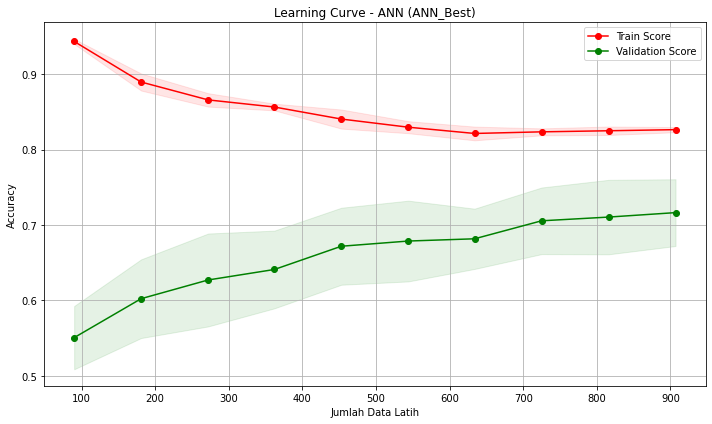

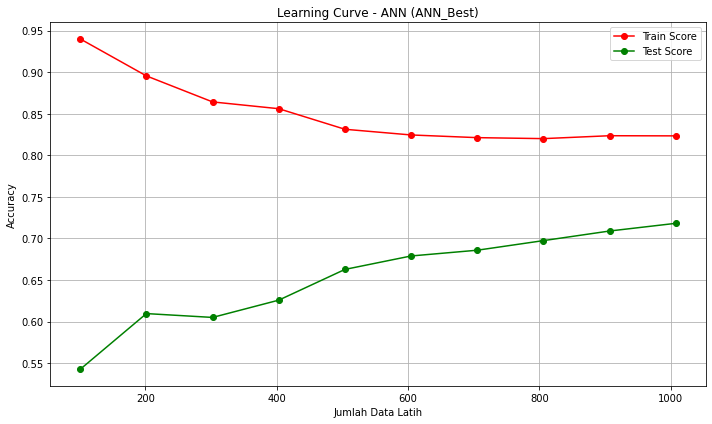

In [122]:
results_ann_tuned, metrics_df_cv_ann_tuned, metrics_df_final_ann_tuned = evaluate_tuned_model(
    top_feature_data=data_prep_finetuning,
    train_func=train_ann,
    eval_func=metrics_model,
    tuned_params=best_hyperparam_ann,
    group_name='ANN_Best',
    model_name='ANN',
    cv=10
)

In [123]:
metrics_df_cv_ann_tuned

Feature Group Model     Fold  Train Accuracy  Train Precision  \
0       ANN_Best   ANN  Average        0.827270         0.833391   
1       ANN_Best   ANN        1        0.823594         0.830884   
2       ANN_Best   ANN        2        0.828004         0.832068   
3       ANN_Best   ANN        3        0.820287         0.825899   
4       ANN_Best   ANN        4        0.833517         0.838191   
5       ANN_Best   ANN        5        0.831312         0.836683   
6       ANN_Best   ANN        6        0.834620         0.841106   
7       ANN_Best   ANN        7        0.814774         0.821731   
8       ANN_Best   ANN        8        0.829107         0.835324   
9       ANN_Best   ANN        9        0.828194         0.836603   
10      ANN_Best   ANN       10        0.829295         0.835426   

    Train Recall  Train F1-Score  Val Accuracy  Val Precision  Val Recall  \
0       0.827270        0.826006      0.724208       0.734011    0.724208   
1       0.823594        0.822217      0.762376       0.772192    0.762376   
2       0.828004        0.827386      0.693069       0.692557    0.693069   
3       0.820287        0.819210      0.792079       0.791185    0.792079   
4       0.833517        0.832377      0.683168       0.688403    0.683168   
5       0.831312        0.829725      0.693069       0.713371    0.693069   
6       0.834620        0.832754      0.722772       0.751547    0.722772   
7       0.814774        0.813554      0.782178       0.781880    0.782178   
8       0.829107        0.828082      0.663366       0.682408    0.663366   
9       0.828194        0.826839      0.720000       0.732915    0.720000   
10      0.829295        0.827911      0.730000       0.733648    0.730000   

    Val F1-Score  Duration (s)  
0       0.722259      1.286849  
1       0.758957      1.250765  
2       0.689472      1.306928  
3       0.790856      1.217398  
4       0.678967      1.336955  
5       0.692755      1.259942  
6       0.725402      1.202667  
7       0.778806      1.377716  
8       0.666158      1.322136  
9       0.713480      1.309348  
10      0.727731      1.284633

In [124]:
metrics_df_final_ann_tuned

Feature Group Model  Train Accuracy  Train Precision  Train Recall  \
0      ANN_Best   ANN        0.823413         0.829792      0.823413   

   Train F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score  \
0        0.822126       0.718245        0.729243     0.718245       0.714523   

   Duration (s)  
0      1.402568

In [113]:
ann_tuned_metrics = [
    (metrics_df_cv_ann_tuned, 'metrics_df_cv_ann_tuned.csv'),
    (metrics_df_final_ann_tuned, 'metrics_df_final_ann_tuned.csv'),
]

In [114]:
ann_tuned_results = [
    (results_ann_tuned, 'results_ann_tuned.pkl'),
]

In [117]:
save_csv(ann_tuned_metrics, output_dir_metrics)
save_multiple_dicts(ann_tuned_results, directory='../Ipynb/Results_3/')

Saved: ../Ipynb/Metrics_3/metrics_df_cv_ann_tuned.csv
Saved: ../Ipynb/Metrics_3/metrics_df_final_ann_tuned.csv
Saved: ../Ipynb/Results_3/results_ann_tuned.pkl


### **Adaboost Decision Tree**

In [113]:
param_grid_adt = {
    'n_estimators': [100, 200],
    'learning_rate': [0.0001, 0.001, 0.01],
    'estimator__max_depth': [ 5, 7, 11, 13],
    'estimator__min_samples_split': [3, 6],
    'estimator__min_samples_leaf': [1, 3],
    'estimator__criterion': ['gini', 'entropy']
}

In [114]:
best_hyperparam_dt, results_tune_dt = hyperparameter_tuning(
    data_prep_finetuning,
    train_adaboost_dt,
    'AdaBoost DT',
    param_grid_adt,
    n_splits=10,
    target_groups=['AdaBoost_DT_Best']
)


=== Hyperparameter Tuning Grup: AdaBoost_DT_Best ===

Evaluasi kombinasi hyperparameter: {'n_estimators': 100, 'learning_rate': 0.0001, 'estimator__max_depth': 5, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 1, 'estimator__criterion': 'gini'}

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

=== Melatih Model AdaBoost dengan Decision Tree ===

Evaluasi kombinasi hyperparameter: {'n_estimators': 100, 'learning_rate': 0.0001, 'estimator__max_depth': 5, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 1, 'estimator__criterion': 'e

In [115]:
best_hyperparam_dt

{'n_estimators': 200,
 'learning_rate': 0.001,
 'estimator__max_depth': 7,
 'estimator__min_samples_split': 6,
 'estimator__min_samples_leaf': 1,
 'estimator__criterion': 'gini'}

In [116]:
results_tune_dt.head(10)

Group                                    Hyperparameters  \
140  AdaBoost_DT_Best  {'n_estimators': 200, 'learning_rate': 0.001, ...   
136  AdaBoost_DT_Best  {'n_estimators': 200, 'learning_rate': 0.001, ...   
138  AdaBoost_DT_Best  {'n_estimators': 200, 'learning_rate': 0.001, ...   
142  AdaBoost_DT_Best  {'n_estimators': 200, 'learning_rate': 0.001, ...   
48   AdaBoost_DT_Best  {'n_estimators': 100, 'learning_rate': 0.001, ...   
148  AdaBoost_DT_Best  {'n_estimators': 200, 'learning_rate': 0.001, ...   
40   AdaBoost_DT_Best  {'n_estimators': 100, 'learning_rate': 0.001, ...   
146  AdaBoost_DT_Best  {'n_estimators': 200, 'learning_rate': 0.001, ...   
150  AdaBoost_DT_Best  {'n_estimators': 200, 'learning_rate': 0.001, ...   
52   AdaBoost_DT_Best  {'n_estimators': 100, 'learning_rate': 0.001, ...   

     Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
140        0.824294         0.836222      0.824294        0.822757   
136        0.825286         0.836263      0.825286        0.823742   
138        0.820546         0.833179      0.820546        0.818979   
142        0.820546         0.833179      0.820546        0.818979   
48         0.830137         0.838830      0.830137        0.828475   
148        0.830357         0.838351      0.830357        0.828821   
40         0.815917         0.829486      0.815917        0.814635   
146        0.829585         0.837218      0.829585        0.828087   
150        0.829585         0.837218      0.829585        0.828087   
52         0.829475         0.838151      0.829475        0.827868   

     Test Accuracy  Test Precision  Test Recall  Test F1-Score  
140       0.737119        0.749170     0.737119       0.734077  
136       0.737109        0.750342     0.737109       0.734168  
138       0.736119        0.750872     0.736119       0.733055  
142       0.736119        0.750872     0.736119       0.733055  
48        0.735119        0.744609     0.735119       0.731411  
148       0.734139        0.745334     0.734139       0.731029  
40        0.732149        0.746137     0.732149       0.729677  
146       0.732149        0.743630     0.732149       0.729120  
150       0.732149        0.743630     0.732149       0.729120  
52        0.731168        0.742395     0.731168       0.727772


=== Evaluating AdaBoost DT for AdaBoost_DT_Best ===

Starting 10-fold cross-validation for AdaBoost DT on AdaBoost_DT_Best

--- Fold 1 ---

=== Melatih Model AdaBoost dengan Decision Tree ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.7200    0.7826    0.7500        23
           1     0.7778    0.5385    0.6364        26
           2     0.6667    0.8571    0.7500        28
           3     0.7727    0.7083    0.7391        24

    accuracy                         0.7228       101
   macro avg     0.7343    0.7216    0.7189       101
weighted avg     0.7326    0.7228    0.7182       101

Duration for Fold 1: 0.84 seconds

--- Fold 2 ---

=== Melatih Model AdaBoost dengan Decision Tree ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.6364    0.6087    0.6222        23
           1     0.7500    0.5769    0.6522        26
           2     0.7

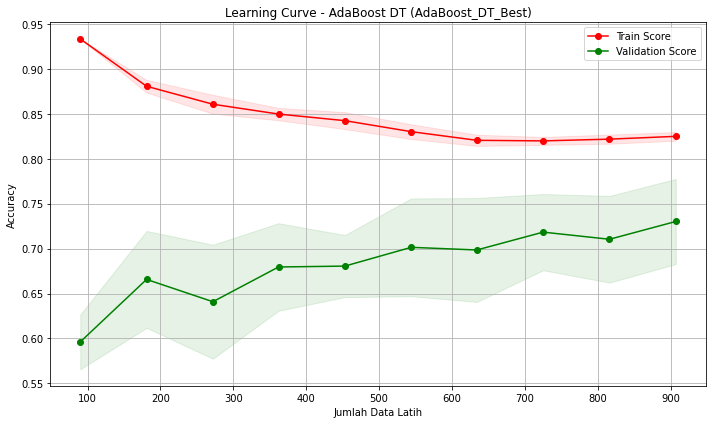

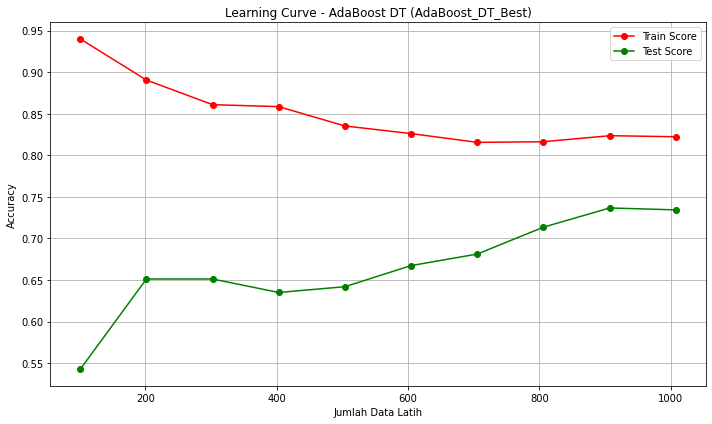

In [118]:
results_adaboost_dt_tuned, metrics_df_cv_adaboost_dt_tuned, metrics_df_final_adaboost_dt_tuned = evaluate_tuned_model(
    top_feature_data=data_prep_finetuning,
    train_func=train_adaboost_dt,
    eval_func=metrics_model,
    tuned_params=best_hyperparam_dt,
    group_name='AdaBoost_DT_Best',
    model_name='AdaBoost DT',
    cv=10
)

In [119]:
metrics_df_cv_adaboost_dt_tuned

Feature Group        Model     Fold  Train Accuracy  Train Precision  \
0   AdaBoost_DT_Best  AdaBoost DT  Average        0.824294         0.836222   
1   AdaBoost_DT_Best  AdaBoost DT        1        0.820287         0.837795   
2   AdaBoost_DT_Best  AdaBoost DT        2        0.823594         0.837394   
3   AdaBoost_DT_Best  AdaBoost DT        3        0.823594         0.836331   
4   AdaBoost_DT_Best  AdaBoost DT        4        0.823594         0.836471   
5   AdaBoost_DT_Best  AdaBoost DT        5        0.825799         0.835769   
6   AdaBoost_DT_Best  AdaBoost DT        6        0.831312         0.841338   
7   AdaBoost_DT_Best  AdaBoost DT        7        0.818082         0.833950   
8   AdaBoost_DT_Best  AdaBoost DT        8        0.826902         0.836050   
9   AdaBoost_DT_Best  AdaBoost DT        9        0.821586         0.832985   
10  AdaBoost_DT_Best  AdaBoost DT       10        0.828194         0.834141   

    Train Recall  Train F1-Score  Val Accuracy  Val Precision  Val Recall  \
0       0.824294        0.822757      0.737119       0.749170    0.737119   
1       0.820287        0.818312      0.722772       0.732617    0.722772   
2       0.823594        0.822275      0.732673       0.730586    0.732673   
3       0.823594        0.822864      0.782178       0.781317    0.782178   
4       0.823594        0.822219      0.732673       0.766927    0.732673   
5       0.825799        0.824951      0.683168       0.699253    0.683168   
6       0.831312        0.828637      0.742574       0.766324    0.742574   
7       0.818082        0.816016      0.772277       0.775801    0.772277   
8       0.826902        0.824394      0.712871       0.729729    0.712871   
9       0.821586        0.820980      0.750000       0.768697    0.750000   
10      0.828194        0.826926      0.740000       0.740448    0.740000   

    Val F1-Score  Duration (s)  
0       0.734077      0.810833  
1       0.718164      0.841165  
2       0.726975      0.814898  
3       0.780320      0.822927  
4       0.730793      0.793017  
5       0.681592      0.796554  
6       0.742782      0.803595  
7       0.769441      0.815155  
8       0.714085      0.774175  
9       0.742921      0.800023  
10      0.733694      0.846820

In [120]:
metrics_df_final_adaboost_dt_tuned

Feature Group        Model  Train Accuracy  Train Precision  \
0  AdaBoost_DT_Best  AdaBoost DT        0.822421         0.828978   

   Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0      0.822421        0.820859       0.734411        0.744099     0.734411   

   Test F1-Score  Duration (s)  
0       0.731928       0.94269

In [102]:
adt_tuned_metrics = [
    (metrics_df_cv_adaboost_dt_tuned, 'metrics_df_cv_adaboost_dt_tuned.csv'),
    (metrics_df_final_adaboost_dt_tuned, 'metrics_df_final_adaboost_dt_tuned.csv'),
]

In [103]:
adt_tuned_results = [
    (results_adaboost_dt_tuned, 'results_adaboost_dt_tuned.pkl'),
]

In [106]:
save_csv(adt_tuned_metrics, output_dir_metrics)
save_multiple_dicts(adt_tuned_results, directory='../Ipynb/Results_3/')

Saved: ../Ipynb/Metrics_3/metrics_df_cv_adaboost_dt_tuned.csv
Saved: ../Ipynb/Metrics_3/metrics_df_final_adaboost_dt_tuned.csv
Saved: ../Ipynb/Results_3/results_adaboost_dt_tuned.pkl


### **Adaboost Support Vector Machine (SVM) Kernel RBF**

In [117]:
param_grid_asvm = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__C': [0.1, 0.25, 0.5, 1.0],
    'estimator__gamma': [10, 12, 14, 15]
}

In [118]:
best_hyperparam_asvm, results_tune_asvm = hyperparameter_tuning(
    data_prep_finetuning,
    train_adaboost_svm,
    'AdaBoost SVM',
    param_grid_asvm,
    n_splits=10,
    target_groups=['AdaBoost_SVM_Best']
)


=== Hyperparameter Tuning Grup: AdaBoost_SVM_Best ===

Evaluasi kombinasi hyperparameter: {'n_estimators': 50, 'learning_rate': 0.01, 'estimator__C': 0.1, 'estimator__gamma': 10}

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

Evaluasi kombinasi hyperparameter: {'n_estimators': 50, 'learning_rate': 0.01, 'estimator__C': 0.1, 'estimator__gamma': 12}

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===

=== Melatih Model AdaBoost dengan SVM RBF Kern

In [86]:
best_hyperparam_asvm

{'n_estimators': 75,
 'learning_rate': 0.1,
 'estimator__C': 1.0,
 'estimator__gamma': 15}

In [125]:
best_hyperparam_asvm = {'n_estimators': 75,
 'learning_rate': 0.1,
 'estimator__C': 1.0,
 'estimator__gamma': 15}

In [120]:
results_tune_asvm.head(10)

Group                                    Hyperparameters  \
79  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
73  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
74  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
75  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
77  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
78  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
72  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
76  AdaBoost_SVM_Best  {'n_estimators': 75, 'learning_rate': 0.1, 'es...   
25  AdaBoost_SVM_Best  {'n_estimators': 50, 'learning_rate': 0.1, 'es...   
29  AdaBoost_SVM_Best  {'n_estimators': 50, 'learning_rate': 0.1, 'es...   

    Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
79        0.824074         0.834144      0.824074        0.822716   
73        0.820987         0.831593      0.820987        0.819548   
74        0.823302         0.834240      0.823302        0.821781   
75        0.824294         0.835260      0.824294        0.822709   
77        0.820436         0.830171      0.820436        0.819333   
78        0.824074         0.833788      0.824074        0.822723   
72        0.815696         0.825992      0.815696        0.814734   
76        0.814153         0.823735      0.814153        0.813279   
25        0.820326         0.830340      0.820326        0.819074   
29        0.819113         0.828486      0.819113        0.818119   

    Test Accuracy  Test Precision  Test Recall  Test F1-Score  
79       0.726198        0.739902     0.726198       0.723454  
73       0.723248        0.736720     0.723248       0.720046  
74       0.722228        0.738403     0.722228       0.718427  
75       0.722218        0.738584     0.722218       0.717972  
77       0.721238        0.732350     0.721238       0.718449  
78       0.721228        0.732226     0.721228       0.718481  
72       0.719267        0.730713     0.719267       0.716085  
76       0.719238        0.728350     0.719238       0.716233  
25       0.718267        0.729116     0.718267       0.714622  
29       0.717277        0.727080     0.717277       0.713777


=== Evaluating AdaBoost SVM for AdaBoost_SVM_Best ===

Starting 10-fold cross-validation for AdaBoost SVM on AdaBoost_SVM_Best

--- Fold 1 ---

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.7391    0.7391    0.7391        23
           1     0.7273    0.6154    0.6667        26
           2     0.7059    0.8571    0.7742        28
           3     0.8636    0.7917    0.8261        24

    accuracy                         0.7525       101
   macro avg     0.7590    0.7508    0.7515       101
weighted avg     0.7564    0.7525    0.7509       101

Duration for Fold 1: 22.46 seconds

--- Fold 2 ---

=== Melatih Model AdaBoost dengan SVM RBF Kernel ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.7273    0.6957    0.7111        23
           1     0.7500    0.5769    0.6522        26
           2 

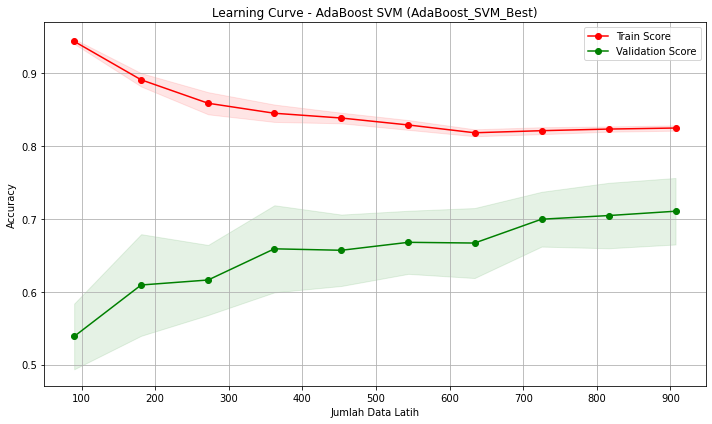

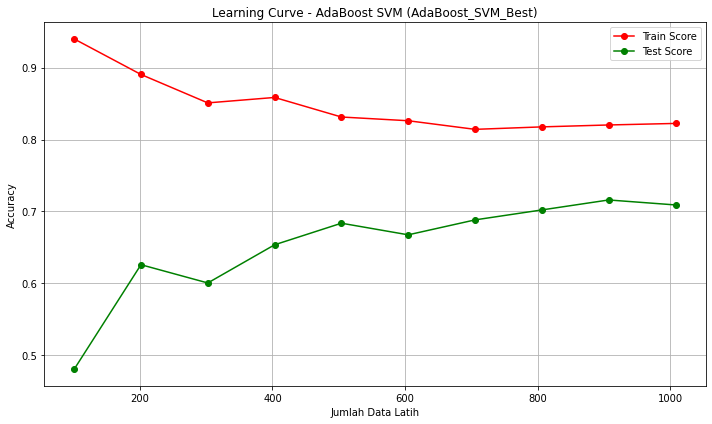

In [126]:
results_adaboost_svm_tuned, metrics_df_cv_adaboost_svm_tuned, metrics_df_final_adaboost_svm_tuned = evaluate_tuned_model(
    top_feature_data=data_prep_finetuning,
    train_func=train_adaboost_svm,
    eval_func=metrics_model,
    tuned_params=best_hyperparam_asvm,
    group_name='AdaBoost_SVM_Best',
    model_name='AdaBoost SVM',
    cv=10
)

In [127]:
metrics_df_cv_adaboost_svm_tuned

Feature Group         Model     Fold  Train Accuracy  Train Precision  \
0   AdaBoost_SVM_Best  AdaBoost SVM  Average        0.824074         0.834144   
1   AdaBoost_SVM_Best  AdaBoost SVM        1        0.819184         0.829464   
2   AdaBoost_SVM_Best  AdaBoost SVM        2        0.824697         0.833607   
3   AdaBoost_SVM_Best  AdaBoost SVM        3        0.821389         0.831834   
4   AdaBoost_SVM_Best  AdaBoost SVM        4        0.824697         0.834654   
5   AdaBoost_SVM_Best  AdaBoost SVM        5        0.825799         0.840105   
6   AdaBoost_SVM_Best  AdaBoost SVM        6        0.829107         0.839374   
7   AdaBoost_SVM_Best  AdaBoost SVM        7        0.815877         0.825267   
8   AdaBoost_SVM_Best  AdaBoost SVM        8        0.826902         0.833889   
9   AdaBoost_SVM_Best  AdaBoost SVM        9        0.825991         0.836284   
10  AdaBoost_SVM_Best  AdaBoost SVM       10        0.827093         0.836966   

    Train Recall  Train F1-Score  Val Accuracy  Val Precision  Val Recall  \
0       0.824074        0.822716      0.726198       0.739902    0.726198   
1       0.819184        0.817648      0.752475       0.756446    0.752475   
2       0.824697        0.823951      0.752475       0.752233    0.752475   
3       0.821389        0.820291      0.772277       0.770192    0.772277   
4       0.824697        0.823967      0.702970       0.715201    0.702970   
5       0.825799        0.824959      0.683168       0.711748    0.683168   
6       0.829107        0.826563      0.702970       0.740201    0.702970   
7       0.815877        0.814566      0.752475       0.759478    0.752475   
8       0.826902        0.825369      0.683168       0.693123    0.683168   
9       0.825991        0.824399      0.690000       0.720046    0.690000   
10      0.827093        0.825450      0.770000       0.780347    0.770000   

    Val F1-Score  Duration (s)  
0       0.723454     22.438003  
1       0.750860     22.461221  
2       0.747573     23.110241  
3       0.770515     23.288074  
4       0.703641     22.105113  
5       0.683574     20.992309  
6       0.704099     21.249442  
7       0.750165     22.170142  
8       0.681597     22.453540  
9       0.679827     22.972485  
10      0.762685     23.577462

In [128]:
metrics_df_final_adaboost_svm_tuned

Feature Group         Model  Train Accuracy  Train Precision  \
0  AdaBoost_SVM_Best  AdaBoost SVM        0.822421         0.832009   

   Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0      0.822421        0.820673       0.709007        0.729631     0.709007   

   Test F1-Score  Duration (s)  
0       0.706228     31.040196

In [124]:
asvm_tuned_metrics = [
    (metrics_df_cv_adaboost_svm_tuned, 'metrics_df_cv_adaboost_svm_tuned.csv'),
    (metrics_df_final_adaboost_svm_tuned, 'metrics_df_final_adaboost_svm_tuned.csv'),
]

In [125]:
asvm_tuned_results = [
    (results_adaboost_svm_tuned, 'results_adaboost_svm_tuned.pkl'),
]

In [126]:
save_csv(asvm_tuned_metrics, output_dir_metrics)
save_multiple_dicts(asvm_tuned_results, directory='../Ipynb/Results_3/')

Saved: ../Ipynb/Metrics_3/metrics_df_cv_adaboost_svm_tuned.csv
Saved: ../Ipynb/Metrics_3/metrics_df_final_adaboost_svm_tuned.csv
Saved: ../Ipynb/Results_3/results_adaboost_svm_tuned.pkl


### **Bagging Support Vector Machine (SVM) Kernel RBF**

In [91]:

param_grid_bsvm = {
    'n_estimators': [150, 200],
    'max_samples': [0.8, 1.0],
    'max_features': [0.8, 1.0],
    'estimator__C': [0.5, 1.0, 2.0],
    'estimator__gamma': [8, 10, 12]
}

In [92]:
best_hyperparam_bsvm, results_tune_bsvm = hyperparameter_tuning(
    data_prep_finetuning,
    train_bagging_svm,
    'Bagging SVM',
    param_grid_bsvm,
    n_splits=10,
    target_groups=['Bagging_SVM_Best']
)


=== Hyperparameter Tuning Grup: Bagging_SVM_Best ===

Evaluasi kombinasi hyperparameter: {'n_estimators': 150, 'max_samples': 0.8, 'max_features': 0.8, 'estimator__C': 0.5, 'estimator__gamma': 8}

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

Evaluasi kombinasi hyperparameter: {'n_estimators': 150, 'max_samples': 0.8, 'max_features': 0.8, 'estimator__C': 0.5, 'estimator__gamma': 10}

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagging dengan SVM RBF Kernel ===

=== Melatih Model Bagg

In [91]:
best_hyperparam_bsvm

{'n_estimators': 200,
 'max_samples': 0.8,
 'max_features': 0.8,
 'estimator__C': 1.0,
 'estimator__gamma': 8}

In [129]:
best_hyperparam_bsvm = {'n_estimators': 200,
 'max_samples': 0.8,
 'max_features': 0.8,
 'estimator__C': 1.0,
 'estimator__gamma': 8}

In [94]:
results_tune_bsvm

Group                                    Hyperparameters  \
60  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 1.0, 'max...   
39  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 0.8, 'max...   
56  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 1.0, 'max...   
41  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 0.8, 'max...   
38  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 0.8, 'max...   
..               ...                                                ...   
46  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 0.8, 'max...   
10  Bagging_SVM_Best  {'n_estimators': 150, 'max_samples': 0.8, 'max...   
64  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 1.0, 'max...   
28  Bagging_SVM_Best  {'n_estimators': 150, 'max_samples': 1.0, 'max...   
47  Bagging_SVM_Best  {'n_estimators': 200, 'max_samples': 0.8, 'max...   

    Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
60        0.786816         0.795208      0.786816        0.785515   
39        0.775351         0.783541      0.775351        0.774140   
56        0.778879         0.786322      0.778879        0.777354   
41        0.783068         0.791444      0.783068        0.781474   
38        0.775351         0.782851      0.775351        0.773862   
..             ...              ...           ...             ...   
46        0.808532         0.817383      0.808532        0.807669   
10        0.808091         0.816486      0.808091        0.807255   
64        0.810626         0.819689      0.810626        0.809781   
28        0.812169         0.821478      0.812169        0.811372   
47        0.814153         0.823530      0.814153        0.813326   

    Test Accuracy  Test Precision  Test Recall  Test F1-Score  
60       0.740079        0.754357     0.740079       0.736976  
39       0.740079        0.753664     0.740079       0.736893  
56       0.740079        0.753520     0.740079       0.736618  
41       0.740079        0.752888     0.740079       0.736506  
38       0.739089        0.752405     0.739089       0.735441  
..            ...             ...          ...            ...  
46       0.716327        0.728521     0.716327       0.713887  
10       0.716327        0.728312     0.716327       0.714029  
64       0.714337        0.725648     0.714337       0.711995  
28       0.714327        0.725563     0.714327       0.712069  
47       0.713337        0.725628     0.713337       0.711183  

[72 rows x 10 columns]


=== Evaluating Bagging SVM for Bagging_SVM_Best ===

Starting 10-fold cross-validation for Bagging SVM on Bagging_SVM_Best

--- Fold 1 ---

=== Melatih Model Bagging dengan SVM RBF Kernel ===
Classification Report Fold 1 (Validation):
              precision    recall  f1-score   support

           0     0.7500    0.7826    0.7660        23
           1     0.8333    0.5769    0.6818        26
           2     0.7097    0.7857    0.7458        28
           3     0.7500    0.8750    0.8077        24

    accuracy                         0.7525       101
   macro avg     0.7608    0.7551    0.7503       101
weighted avg     0.7603    0.7525    0.7486       101

Duration for Fold 1: 2.81 seconds

--- Fold 2 ---

=== Melatih Model Bagging dengan SVM RBF Kernel ===
Classification Report Fold 2 (Validation):
              precision    recall  f1-score   support

           0     0.8000    0.6957    0.7442        23
           1     0.7000    0.5385    0.6087        26
           2     0.6

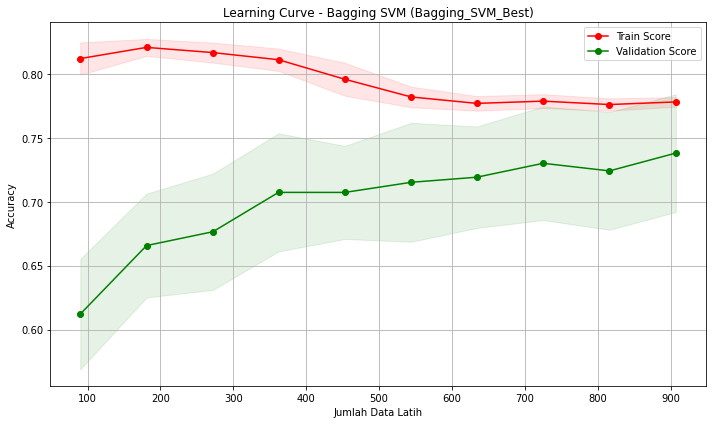

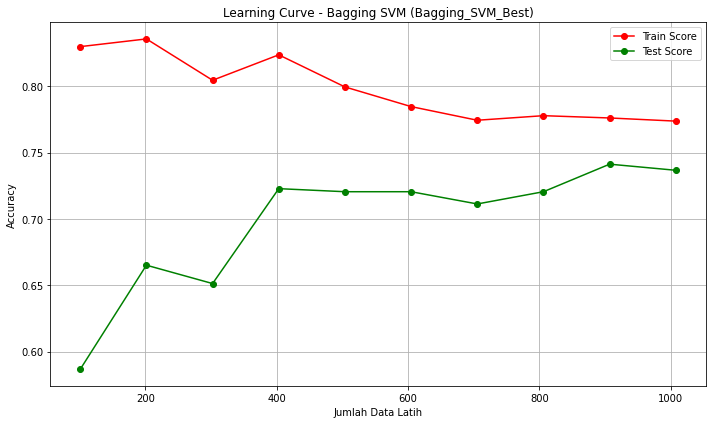

In [130]:
results_bagging_svm_tuned, metrics_df_cv_bagging_svm_tuned, metrics_df_final_bagging_svm_tuned = evaluate_tuned_model(
    top_feature_data=data_prep_finetuning,
    train_func=train_bagging_svm,
    eval_func=metrics_model,
    tuned_params=best_hyperparam_bsvm,
    group_name='Bagging_SVM_Best',
    model_name='Bagging SVM',
    cv=10
)

In [131]:
metrics_df_cv_bagging_svm_tuned

Feature Group        Model     Fold  Train Accuracy  Train Precision  \
0   Bagging_SVM_Best  Bagging SVM  Average        0.775351         0.783541   
1   Bagging_SVM_Best  Bagging SVM        1        0.773980         0.782755   
2   Bagging_SVM_Best  Bagging SVM        2        0.771775         0.780846   
3   Bagging_SVM_Best  Bagging SVM        3        0.771775         0.779862   
4   Bagging_SVM_Best  Bagging SVM        4        0.785006         0.793225   
5   Bagging_SVM_Best  Bagging SVM        5        0.776185         0.785423   
6   Bagging_SVM_Best  Bagging SVM        6        0.773980         0.783276   
7   Bagging_SVM_Best  Bagging SVM        7        0.767365         0.776562   
8   Bagging_SVM_Best  Bagging SVM        8        0.769570         0.777236   
9   Bagging_SVM_Best  Bagging SVM        9        0.781938         0.787682   
10  Bagging_SVM_Best  Bagging SVM       10        0.781938         0.788544   

    Train Recall  Train F1-Score  Val Accuracy  Val Precision  Val Recall  \
0       0.775351        0.774140      0.740079       0.753664    0.740079   
1       0.773980        0.772004      0.752475       0.760274    0.752475   
2       0.771775        0.770727      0.742574       0.742300    0.742574   
3       0.771775        0.770572      0.801980       0.808352    0.801980   
4       0.785006        0.784088      0.732673       0.754393    0.732673   
5       0.776185        0.775544      0.693069       0.739060    0.693069   
6       0.773980        0.772098      0.683168       0.707399    0.683168   
7       0.767365        0.765267      0.772277       0.781540    0.772277   
8       0.769570        0.768217      0.742574       0.748531    0.742574   
9       0.781938        0.781248      0.750000       0.757339    0.750000   
10      0.781938        0.781634      0.730000       0.737449    0.730000   

    Val F1-Score  Duration (s)  
0       0.736893      3.258841  
1       0.748616      2.805991  
2       0.736285      3.969173  
3       0.797399      3.274158  
4       0.729910      2.876601  
5       0.693754      3.818924  
6       0.685137      3.401132  
7       0.765682      3.240453  
8       0.741614      3.186617  
9       0.744154      2.954583  
10      0.726378      3.060774

In [132]:
metrics_df_final_bagging_svm_tuned

Feature Group        Model  Train Accuracy  Train Precision  \
0  Bagging_SVM_Best  Bagging SVM         0.77381         0.781367   

   Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0       0.77381         0.77196       0.736721        0.745159     0.736721   

   Test F1-Score  Duration (s)  
0       0.734294      3.867485

In [ ]:
bsvm_tuned_metrics = [
    (metrics_df_cv_bagging_svm_tuned, 'metrics_df_cv_bagging_svm_tuned.csv'),
    (metrics_df_final_bagging_svm_tuned, 'metrics_df_final_bagging_svm_tuned.csv'),
]

In [ ]:
bsvm_tuned_results = [
    (results_bagging_svm_tuned, 'results_bagging_svm_tuned.pkl'),
]

In [ ]:
save_csv(bsvm_tuned_metrics, output_dir_metrics)
save_multiple_dicts(bsvm_tuned_results, directory='../Ipynb/Results_3/')

Saved: ../Ipynb/Metrics_3/metrics_df_cv_bagging_svm_tuned.csv
Saved: ../Ipynb/Metrics_3/metrics_df_final_bagging_svm_tuned.csv
Saved: ../Ipynb/Results_3/results_bagging_svm_tuned.pkl


# **Perbandingan Metriks Evaluasi**

## **Import library**

In [133]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Inisiasi Parameter**

In [134]:
model_names = ['ANN', 'AdaBoost DT', 'AdaBoost SVM', 'Bagging SVM']

In [135]:
# Menggabungkan data metrics dengan CV
metrics_dict_cv = pd.concat([
    metrics_df_ann_cv.copy(),
    metrics_df_adaboost_dt_cv.copy(),
    metrics_df_adaboost_svm_cv.copy(),
    metrics_df_bagging_svm_cv.copy()
], ignore_index=True)

# Menggabungkan data metrics feature selection (FS) dengan CV
metrics_dict_fs_cv = pd.concat([
    metrics_fs_ann_cv.copy(),
    metrics_fs_adaboost_dt_cv.copy(),
    metrics_fs_adaboost_svm_cv.copy(),
    metrics_fs_bagging_svm_cv.copy()
], ignore_index=True)


In [136]:
# Menggabungkan data results dengan CV
results_dict_cv = {
    'ANN': results_ann_cv,
    'AdaBoost DT': results_adaboost_dt_cv,
    'AdaBoost SVM': results_adaboost_svm_cv,
    'Bagging SVM': results_bagging_svm_cv,
}

# Menggabungkan data results feature selection (FS) dengan CV
results_dict_fs_cv = {
    'ANN': results_fs_ann_cv,
    'AdaBoost DT': results_fs_adaboost_dt_cv,
    'AdaBoost SVM': results_fs_adaboost_svm_cv,
    'Bagging SVM': results_fs_bagging_svm_cv,
}

In [137]:
import joblib
import pandas as pd

In [138]:
# Load data hyperparameter tuning
results_ann_tuned = joblib.load('../Ipynb/Results_3/results_ann_tuned.pkl')
metrics_df_cv_ann_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_cv_ann_tuned.csv')
metrics_df_final_ann_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_final_ann_tuned.csv')

results_adaboost_dt_tuned = joblib.load('../Ipynb/Results_3/results_adaboost_dt_tuned.pkl')
metrics_df_cv_adaboost_dt_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_cv_adaboost_dt_tuned.csv')
metrics_df_final_adaboost_dt_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_final_adaboost_dt_tuned.csv')

results_adaboost_svm_tuned = joblib.load('../Ipynb/Results_3/results_adaboost_svm_tuned.pkl')
metrics_df_cv_adaboost_svm_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_cv_adaboost_svm_tuned.csv')
metrics_df_final_adaboost_svm_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_final_adaboost_svm_tuned.csv')

results_bagging_svm_tuned = joblib.load('../Ipynb/Results_3/results_bagging_svm_tuned.pkl')
metrics_df_cv_bagging_svm_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_cv_bagging_svm_tuned.csv')
metrics_df_final_bagging_svm_tuned = pd.read_csv('../Ipynb/Metrics_3/metrics_df_final_bagging_svm_tuned.csv')

In [139]:
results_dict_ht = {
    'ANN': results_ann_tuned,
    'AdaBoost DT': results_adaboost_dt_tuned,
    'AdaBoost SVM': results_adaboost_svm_tuned,
    'Bagging SVM': results_bagging_svm_tuned,
}

metrics_df_final_ann_tuned_copy = metrics_df_final_ann_tuned.copy()
metrics_df_final_adaboost_dt_tuned_copy = metrics_df_final_adaboost_dt_tuned.copy()
metrics_df_final_adaboost_svm_tuned_copy = metrics_df_final_adaboost_svm_tuned.copy()
metrics_df_final_bagging_svm_tuned_copy = metrics_df_final_bagging_svm_tuned.copy()

metrics_df_final_dict_ht = pd.concat([
    metrics_df_final_ann_tuned_copy,
    metrics_df_final_adaboost_dt_tuned_copy,
    metrics_df_final_adaboost_svm_tuned_copy,
    metrics_df_final_bagging_svm_tuned_copy
], ignore_index=True)

In [140]:
metrics_df_final_dict_ht

Feature Group         Model  Train Accuracy  Train Precision  \
0           ANN_Best           ANN        0.823413         0.829792   
1   AdaBoost_DT_Best   AdaBoost DT        0.822421         0.828978   
2  AdaBoost_SVM_Best  AdaBoost SVM        0.822421         0.832009   
3   Bagging_SVM_Best   Bagging SVM        0.773810         0.781367   

   Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  \
0      0.823413        0.822126       0.718245        0.729243     0.718245   
1      0.822421        0.820859       0.734411        0.744099     0.734411   
2      0.822421        0.820673       0.709007        0.729631     0.709007   
3      0.773810        0.771960       0.736721        0.745159     0.736721   

   Test F1-Score  Duration (s)  
0       0.714523      1.369071  
1       0.731928      0.927312  
2       0.706228     27.376673  
3       0.734294      3.970437

In [141]:
metrics_df_cv_ann_tuned_copy = metrics_df_cv_ann_tuned.copy()
metrics_df_cv_adaboost_dt_tuned_copy = metrics_df_cv_adaboost_dt_tuned.copy()
metrics_df_cv_adaboost_svm_tuned_copy = metrics_df_cv_adaboost_svm_tuned.copy()
metrics_df_cv_bagging_svm_tuned_copy = metrics_df_cv_bagging_svm_tuned.copy()

metrics_dicts_tuned_cv = pd.concat([
    metrics_df_cv_ann_tuned_copy,
    metrics_df_cv_adaboost_dt_tuned_copy,
    metrics_df_cv_adaboost_svm_tuned_copy,
    metrics_df_cv_bagging_svm_tuned_copy
], ignore_index=True)


# drop semua kolom fold selain average
metrics_dicts_average_cv = metrics_dicts_tuned_cv[metrics_dicts_tuned_cv['Fold'] == 'Average'].copy()
metrics_dicts_average_cv.reset_index(drop=True, inplace=True)

In [142]:
metrics_dicts_tuned_cv2 = metrics_dicts_tuned_cv.copy()
# drop kolom fold yang bernilai selain average
metrics_dicts_tuned_cv2 = metrics_dicts_tuned_cv2[metrics_dicts_tuned_cv2['Fold'] == 'Average']

In [143]:
metrics_dicts_tuned_cv2

Feature Group         Model     Fold  Train Accuracy  Train Precision  \
0            ANN_Best           ANN  Average        0.827270         0.833391   
11   AdaBoost_DT_Best   AdaBoost DT  Average        0.824294         0.836222   
22  AdaBoost_SVM_Best  AdaBoost SVM  Average        0.824074         0.834144   
33   Bagging_SVM_Best   Bagging SVM  Average        0.775351         0.783541   

    Train Recall  Train F1-Score  Val Accuracy  Val Precision  Val Recall  \
0       0.827270        0.826006      0.724208       0.734011    0.724208   
11      0.824294        0.822757      0.737119       0.749170    0.737119   
22      0.824074        0.822716      0.726198       0.739902    0.726198   
33      0.775351        0.774140      0.740079       0.753664    0.740079   

    Val F1-Score  Duration (s)  
0       0.722259      1.285682  
11      0.734077      0.832996  
22      0.723454     21.367189  
33      0.736893      2.934155

## **Confusion Matrix**

### **Fungsi Confusion Matrix**

In [144]:
def visualize_top_feature_combinations(data_prep, results, metrics_df, models=None, top_n=4, method='gb'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Perbesar ukuran font secara global
    plt.rcParams.update({'font.size': 18})

    if models is None:
        models = metrics_df['Model'].unique()

    if len(models) > 1:
        top_n = 1

    num_plots = len(models) * top_n
    rows = (num_plots + 1) // 2
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 8))
    axes = axes.flatten()
    plot_idx = 0

    for model_name in models:
        top_features_df = metrics_df[metrics_df['Model'] == model_name].nlargest(top_n, 'Test Accuracy')
        top_feature_groups = top_features_df['Feature Group'].tolist()

        for feature_group in top_feature_groups:
            if plot_idx >= len(axes):
                break

            # Ambil y_pred berdasarkan method
            if method == 'gb':
                if feature_group not in data_prep:
                    print(f"Skipping {feature_group}: tidak ditemukan di data_prep")
                    continue
                y_test = data_prep[feature_group]['y_test']
                y_pred = results[model_name][feature_group]['test_results']['y_pred']

            elif method == 'ag':
                y_test = data_prep['y_test']
                y_pred = results[model_name][feature_group]['test_results']['y_pred']

            elif method == 'ht':
                y_test = data_prep[feature_group]['y_test']
                y_pred = results[model_name][feature_group]['test_pred']

            else:
                raise ValueError(f"Method '{method}' tidak didukung.")

            # Hitung confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[plot_idx], annot_kws={"size": 16})
            axes[plot_idx].set_title(f'{model_name}\nFeature Group: {feature_group}', fontsize=18)
            axes[plot_idx].set_xlabel('Predicted', fontsize=16)
            axes[plot_idx].set_ylabel('Actual', fontsize=16)

            plot_idx += 1

    # Sembunyikan subplot kosong
    for j in range(plot_idx, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


### **Hyperparameter Tuning**

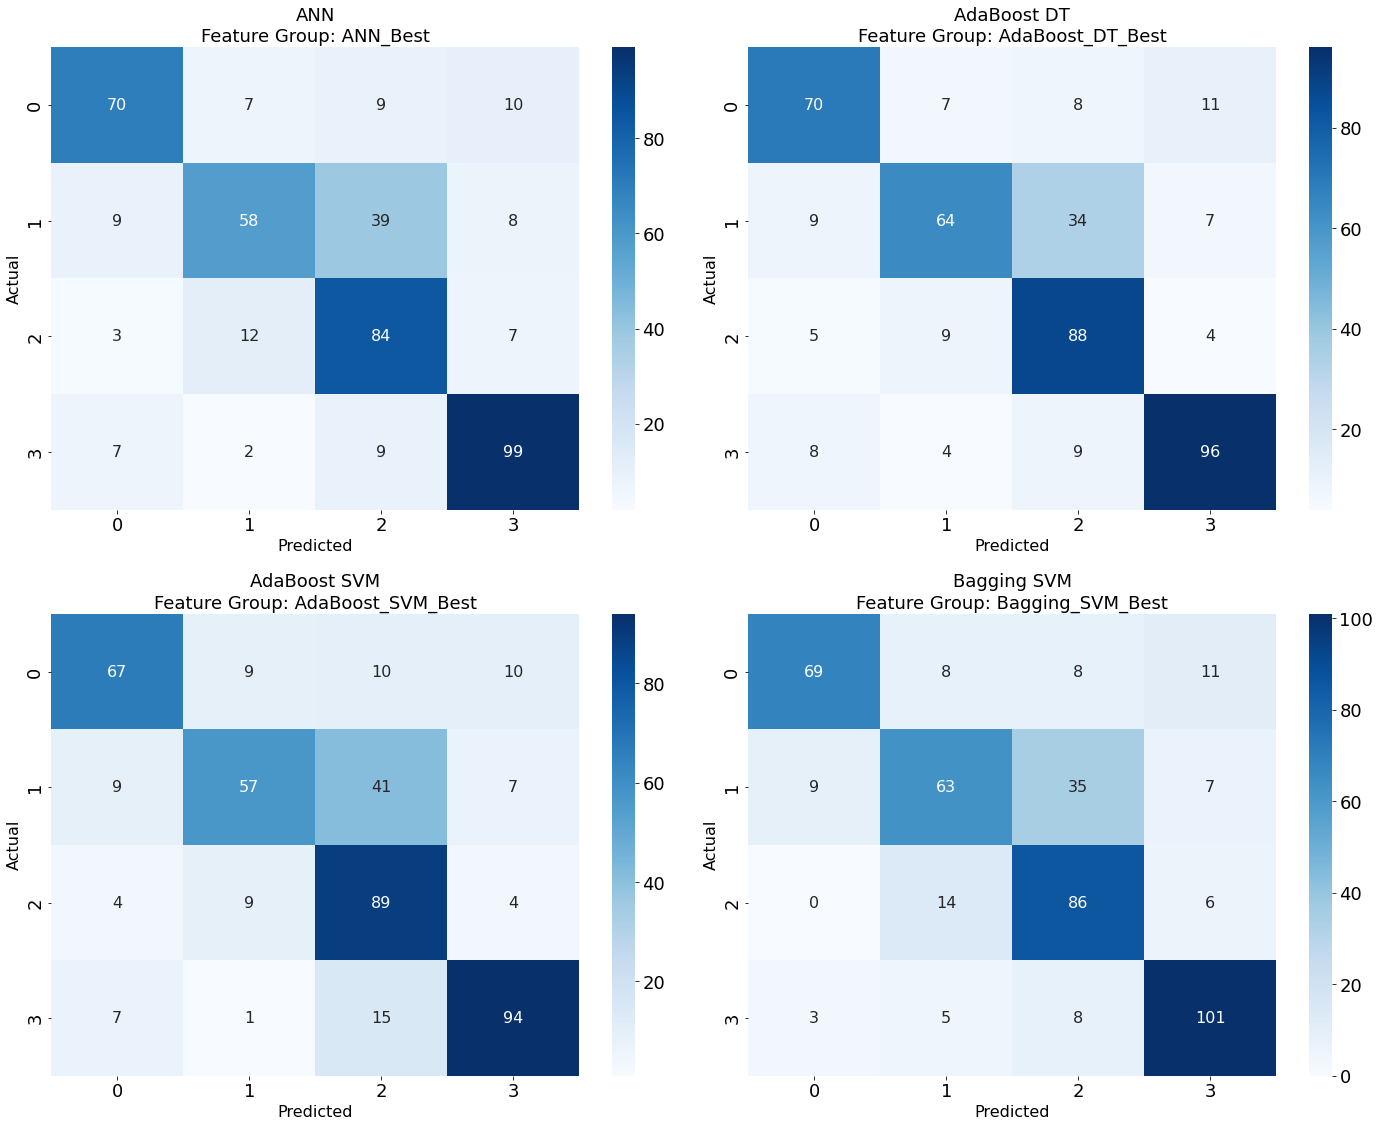

In [145]:
visualize_top_feature_combinations(
    data_prep=data_prep_finetuning,
    results=results_dict_ht,
    metrics_df=metrics_df_final_dict_ht,
    models=model_names,
    method='ht'
)

## **ROC-AUC**

### **Fungsi ROC-AUC**

In [146]:
def plot_roc_per_class(results, data_prep, metrics_df, models=None, method='gb', top_n=4):
    if models is None:
        models = metrics_df['Model'].unique().tolist()

    # Ambil sample y_test untuk cek jumlah kelas
    first_model = models[0]
    top_group_for_first = metrics_df[metrics_df['Model'] == first_model].nlargest(1, 'Test Accuracy')['Feature Group'].iloc[0]

    if method == 'gb':
        y_test_sample = data_prep[top_group_for_first]['y_test']
    elif method == 'ag':
        y_test_sample = data_prep['y_test']
    elif method == 'ht':
        y_test_sample = data_prep[top_group_for_first]['y_test']
    classes = np.unique(y_test_sample)
    n_classes = len(classes)

    # Setup figure dengan grid: 2 kolom per baris
    n_cols = 2
    n_rows = (n_classes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8 * n_rows))
    axes = axes.flatten()  # Flatten agar mudah diiterasi

    # Warna untuk setiap model
    model_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(models)}

    # Loop tiap kelas
    for cls_idx, class_label in enumerate(classes):
        ax = axes[cls_idx]
        ax.set_title(f"Class {class_label} - ROC Curve (All Models)")

        # Loop tiap model
        for model_name in models:
            color = model_color_map[model_name]

            # Ambil grup terbaik untuk model ini
            top_group = metrics_df[metrics_df['Model'] == model_name].nlargest(1, 'Test Accuracy')['Feature Group'].iloc[0]

            # Akses y_test dan y_prob sesuai method
            if method == 'gb':
                if top_group not in data_prep:
                    print(f"Skipping {model_name} ({top_group}): tidak ditemukan di data_prep")
                    continue
                y_test = data_prep[top_group]['y_test']
                y_prob = results[model_name][top_group]['test_results']['y_prob']
            elif method == 'ag':
                y_test = data_prep['y_test']
                y_prob = results[model_name][top_group]['test_results']['y_prob']
            elif method == 'ht':
                y_test = data_prep[top_group]['y_test']
                y_prob = results[model_name][top_group]['test_prob']

            # Binarize y_test untuk kelas tertentu
            y_test_bin = label_binarize(y_test, classes=classes)[:, cls_idx]

            # Hitung FPR, TPR, dan AUC
            fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, cls_idx])
            roc_auc = auc(fpr, tpr)

            # Plot ROC Curve
            if method == 'gb':
                ax.plot(
                    fpr, tpr,
                    color=color,
                    lw=1.5,
                    linestyle='-',
                    label=f'{model_name} ({top_group}, AUC = {roc_auc:.2f})'
                )
            elif method == 'ag' or method == 'ht':
                ax.plot(
                    fpr, tpr,
                    color=color,
                    lw=1.5,
                    linestyle='-',
                    label=f'({top_group}, AUC = {roc_auc:.2f})'
                )

        # Tambahkan diagonal reference line
        ax.plot([0, 1], [0, 1], 'k--', lw=1.5)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")

    # Nonaktifkan axis kosong jika jumlah kelas ganjil
    for i in range(len(classes), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### **Hyperparameter Tuning**

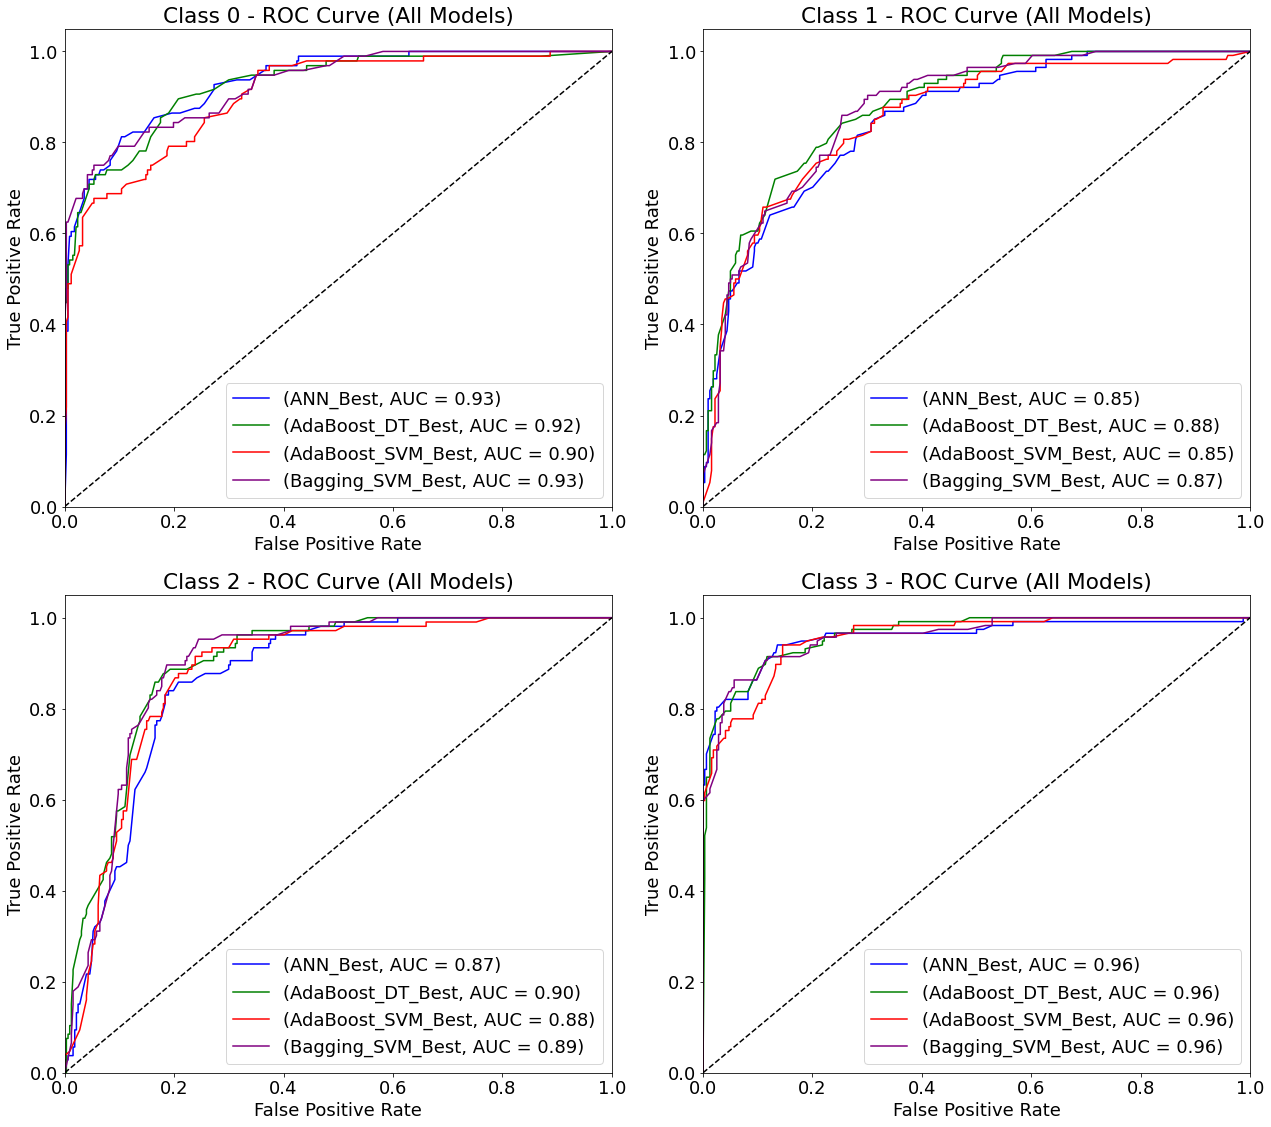

In [147]:
plot_roc_per_class(
    results=results_dict_ht,
    data_prep=data_prep_finetuning,
    metrics_df=metrics_df_final_dict_ht,
    models=model_names,
    method='ht'
)

## **Classification Report**

### **Fungsi Classification Report**

In [172]:
def visualize_model_feature_metrics(all_metrics_df, model_names, top_n=1):

    def get_metric_column(df, metric_name):
        """Mencari kolom metrik yang sesuai (Test atau Val)."""
        if f"Test {metric_name}" in df.columns:
            return f"Test {metric_name}"
        elif f"Val {metric_name}" in df.columns:
            return f"Val {metric_name}"
        else:
            raise KeyError(f"Kolom untuk '{metric_name}' tidak ditemukan dalam DataFrame.")

    n_models = len(model_names)

    # Atur layout grid berdasarkan jumlah model
    cols_per_row = 2 if n_models > 1 else 1  # Jika banyak model, 2 kolom per baris
    rows = (n_models + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 10, rows * 6))
    
    # Flatten axes agar mudah diiterasi
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    plot_idx = 0  # Indeks subplot

    for model_name in model_names:
        # Filter data untuk model tertentu
        model_df = all_metrics_df[all_metrics_df['Model'] == model_name]
        if model_df.empty:
            raise ValueError(f"Tidak ada data untuk model '{model_name}' dalam DataFrame.")

        # Ambil top_n kombinasi fitur berdasarkan Test Accuracy
        accuracy_col = get_metric_column(model_df, "Accuracy")
        top_features_df = model_df.nlargest(top_n, accuracy_col)
        feature_group = top_features_df.iloc[0]['Feature Group']

        ax = axes[plot_idx]

        # Ambil metrik
        metrics = top_features_df.iloc[0]
        labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [
            metrics[get_metric_column(model_df, "Accuracy")],
            metrics[get_metric_column(model_df, "Precision")],
            metrics[get_metric_column(model_df, "Recall")],
            metrics[get_metric_column(model_df, "F1-Score")]
        ]

        # Plot barchart
        bars = sns.barplot(x=labels, y=values, ax=ax, palette='tab10',hue=labels)
        ax.set_title(f"{model_name} - {feature_group}")
        ax.set_ylim(0, 1)
        ax.set_ylabel('Score')
        ax.set_xlabel('Metrics')
        ax.grid(axis='y')

        # Label persentase di atas bar
        for bar, value in zip(bars.patches, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{value:.2%}",
                ha='center',
                va='bottom',
                fontsize=10
            )

        plot_idx += 1

    # Hapus subplot kosong jika ada
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [173]:
def visualize_model_per_plot(all_metrics_df, model_names, top_n=1, phase="Test",
                             color_train='#81C784', color_test='#388E3C'):
    def get_metric_column(df, metric_name, phase="Test"):
        col = f"{phase} {metric_name}"
        if col in df.columns:
            return col
        else:
            raise KeyError(f"Kolom '{col}' tidak ditemukan dalam DataFrame.")

    metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    n_metrics = len(metrics_list)

    for model_name in model_names:
        # Filter data model
        model_df = all_metrics_df[all_metrics_df['Model'] == model_name]
        if model_df.empty:
            raise ValueError(f"Tidak ada data untuk model '{model_name}' dalam DataFrame.")

        best_acc_col = get_metric_column(model_df, "Accuracy", phase=phase)
        top_features_df = model_df.nlargest(top_n, best_acc_col)
        feature_group = top_features_df.iloc[0]['Feature Group']

        # Ambil nilai metrik
        row = top_features_df.iloc[0]

        train_values = [row[get_metric_column(model_df, m, phase="Train")] for m in metrics_list]
        test_values = [row[get_metric_column(model_df, m, phase=phase)] for m in metrics_list]

        x_indexes = np.arange(n_metrics)
        bar_width = 0.35

        # Buat figure baru untuk tiap model
        fig, ax = plt.subplots(figsize=(8, 6))

        bars1 = ax.bar(x_indexes - bar_width/2, train_values, width=bar_width,
                       label='Train', color=color_train)
        bars2 = ax.bar(x_indexes + bar_width/2, test_values, width=bar_width,
                       label=phase, color=color_test)

        # Label persentase di atas bar
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    height,
                    f"{height:.2%}",
                    ha='center',
                    va='bottom',
                    fontsize=9
                )

        # Set title dan label
        ax.set_title(f"{model_name} - {feature_group}")
        ax.set_xticks(x_indexes)
        ax.set_xticklabels(metrics_list)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Score')
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.legend()

        plt.tight_layout()
        plt.show()

### **Gabungan Fitur**

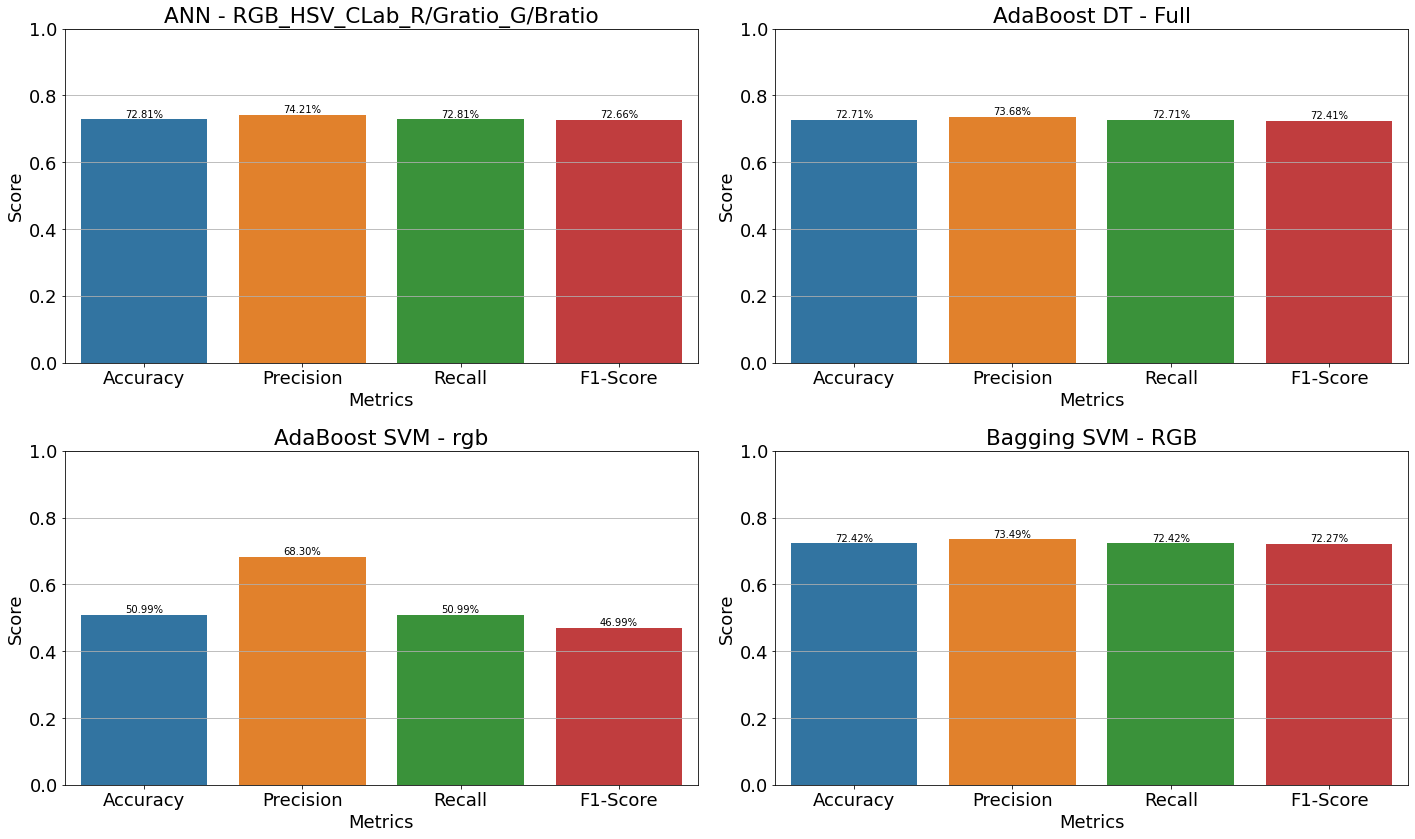

In [174]:
visualize_model_feature_metrics(
    all_metrics_df=metrics_dict_cv,
    model_names=model_names,
)

### **Seleksi Fitur**

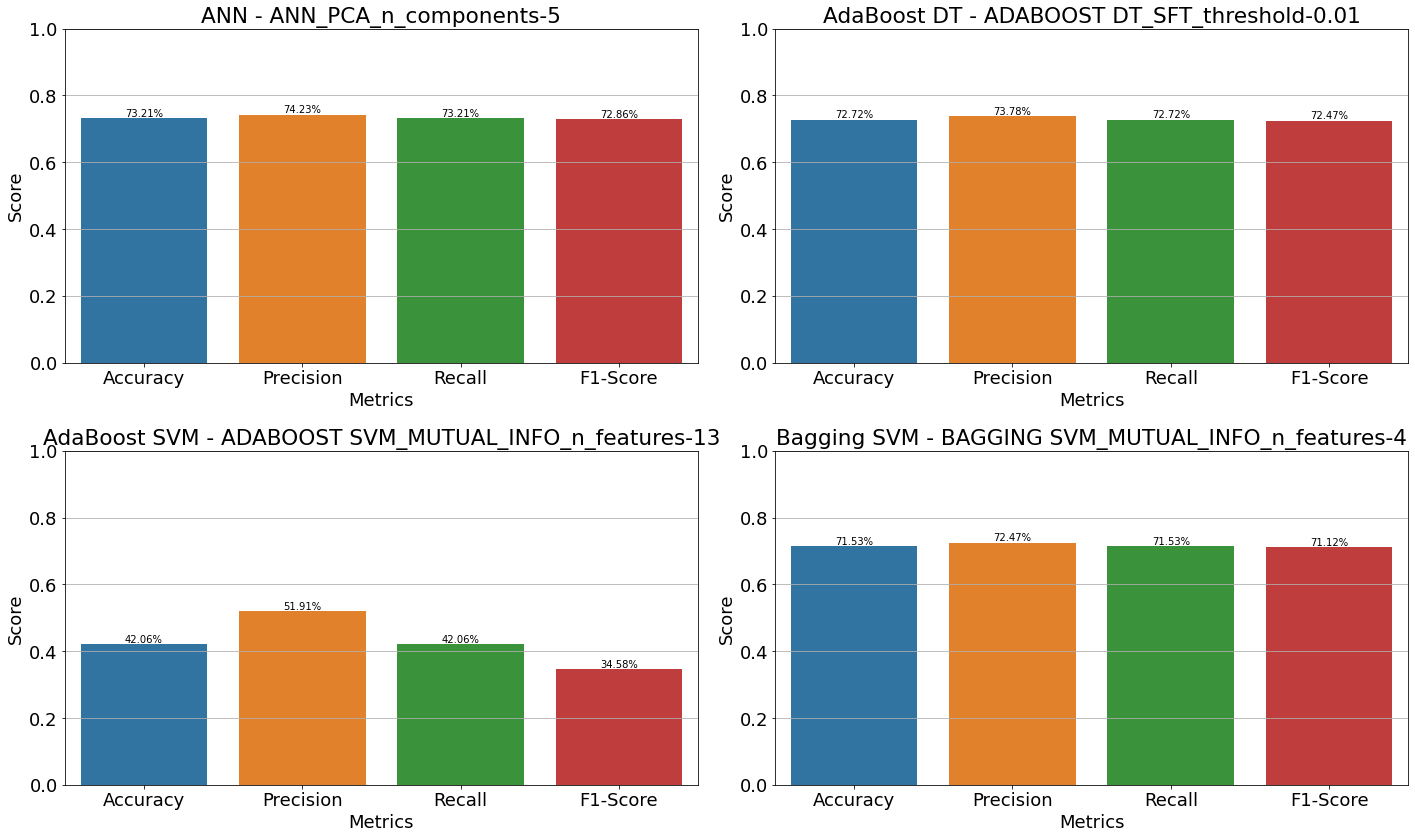

In [175]:
visualize_model_feature_metrics(
    all_metrics_df=metrics_dict_fs_cv,
    model_names=model_names,
)

### **Hyperparameter Tuning**

#### **Cross Validation**

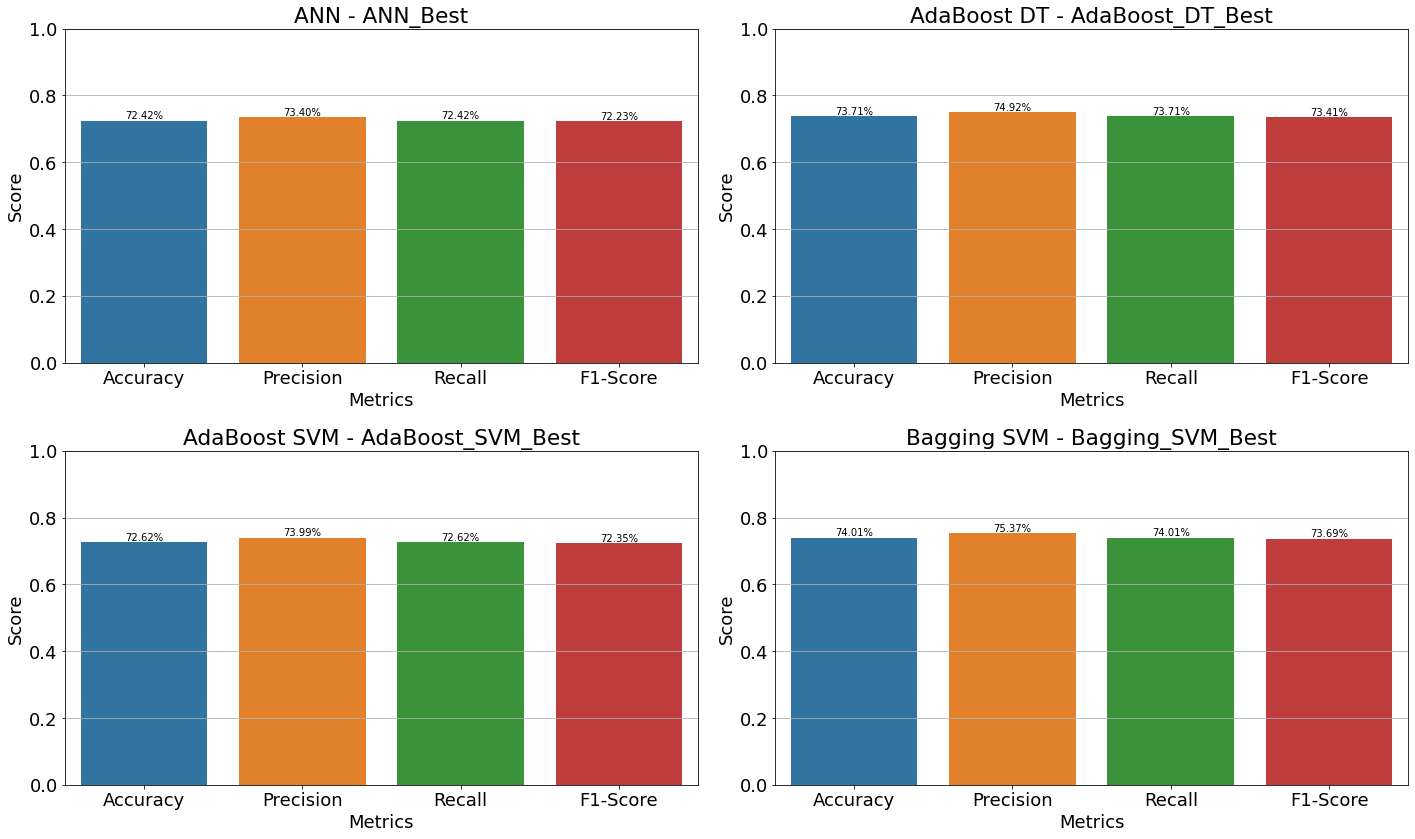

In [176]:
visualize_model_feature_metrics(
    all_metrics_df=metrics_dicts_average_cv,
    model_names=model_names,
)

#### **Final Model**

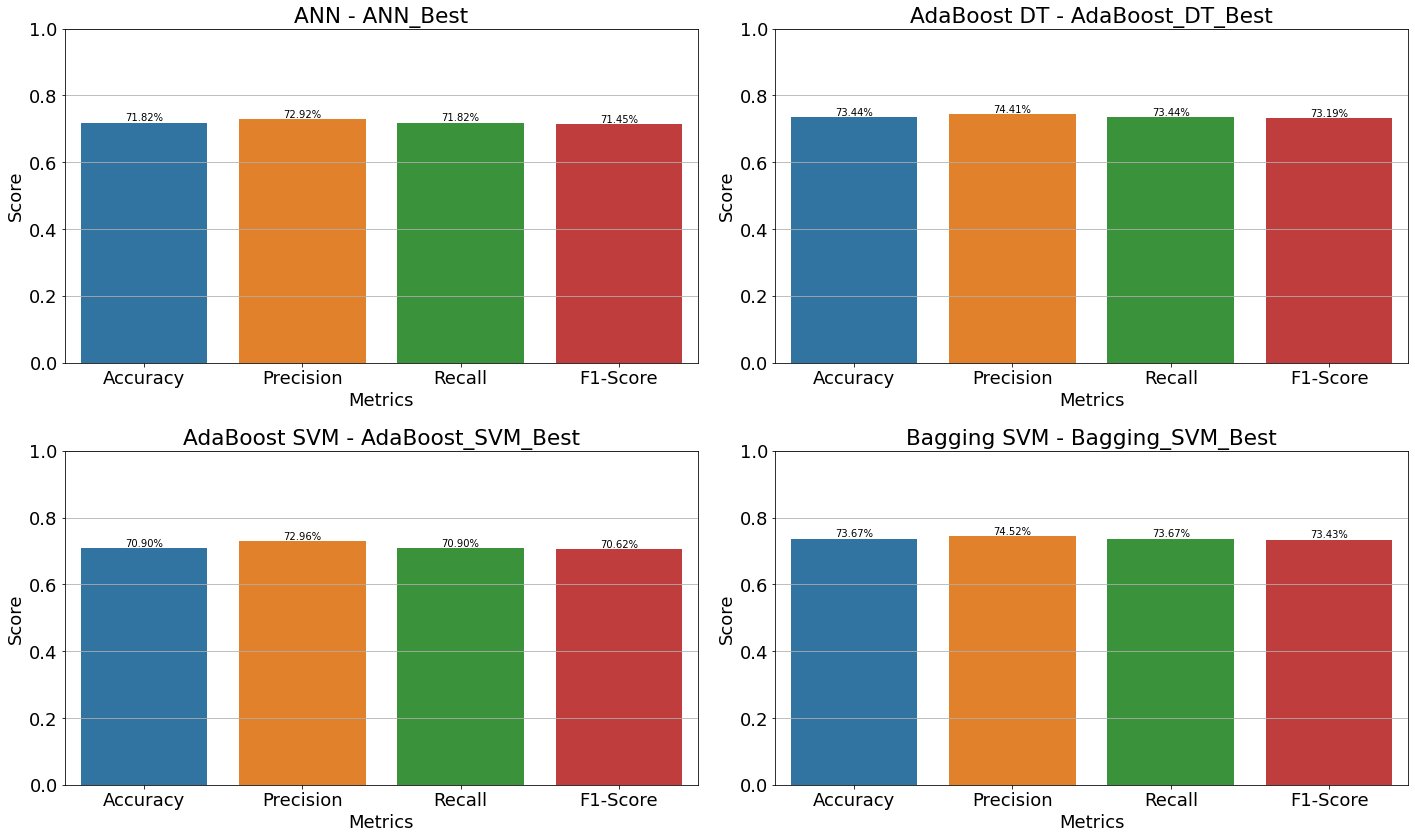

In [177]:
visualize_model_feature_metrics(
    all_metrics_df=metrics_df_final_dict_ht,
    model_names=model_names,
)

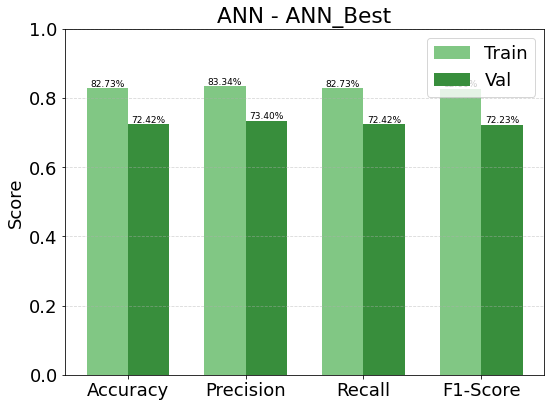

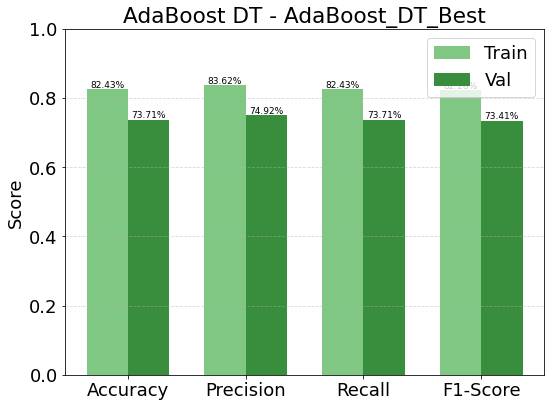

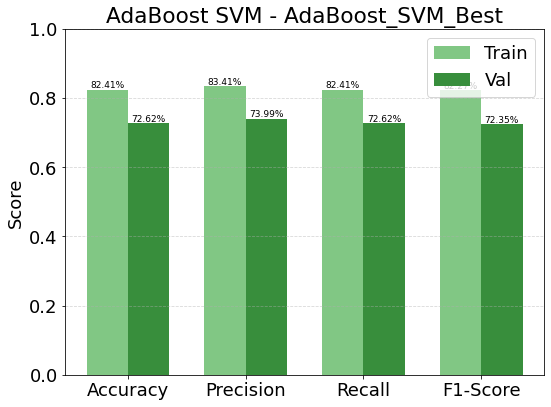

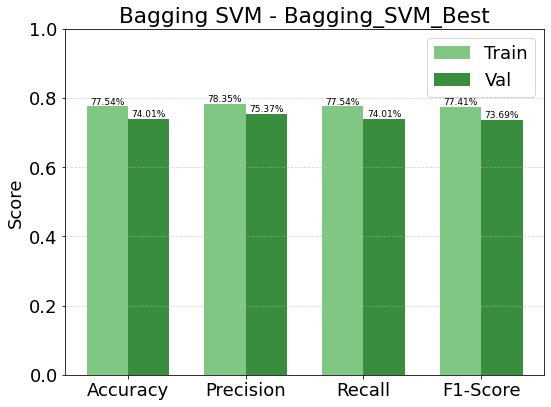

In [178]:
visualize_model_per_plot(
    all_metrics_df=metrics_dicts_average_cv,
    model_names=model_names,
    phase="Val",
)

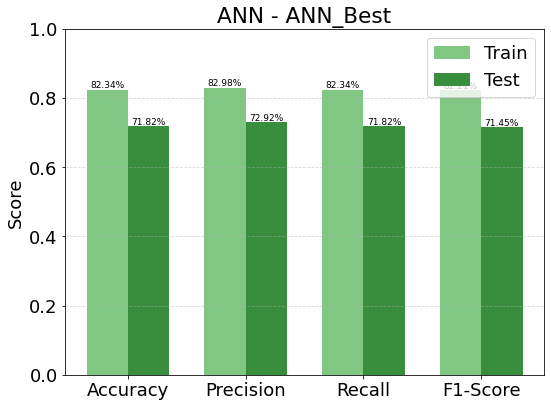

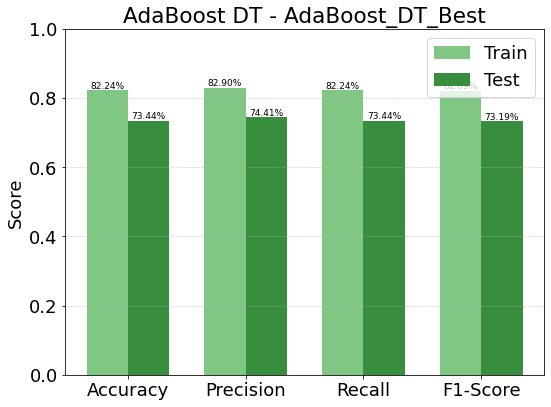

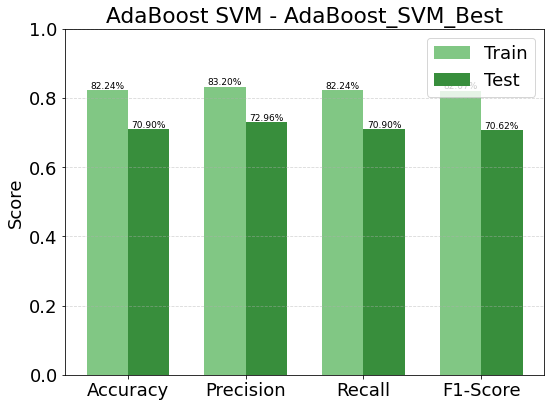

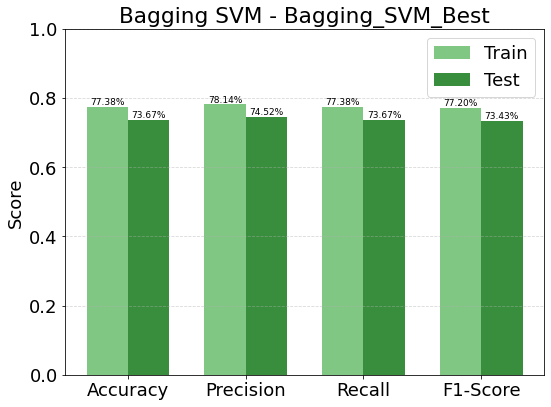

In [179]:
visualize_model_per_plot(
    all_metrics_df=metrics_df_final_dict_ht,
    model_names=model_names,
    phase="Test"
)